# FeatureMAP on synthetic data with Gaussian model.

In [2]:
# import featuremap
from featuremap import *



import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.decomposition import PCA

import warnings
warnings.simplefilter("ignore", category=UserWarning)
warnings.simplefilter("ignore", category=FutureWarning)
warnings.simplefilter("ignore", category=DeprecationWarning)

### Data loading

Helper function for plot.

In [3]:
def plot_func(emb, label, method):

    x_min, x_max = emb[:, 0].min(), emb[:, 0].max()
    y_min, y_max = emb[:, 1].min(), emb[:, 1].max()

    min_lim = min(x_min - (x_min+x_max)/2, y_min - (y_min+y_max)/2)
    max_lim = max(x_max +(x_min+x_max)/2, y_max+ (y_min+y_max)/2)

    plt.figure(figsize=(10, 7))
    plt.scatter(emb[:, 0], emb[:, 1], c=label, cmap='tab10')
    plt.xlim(min_lim, max_lim)
    plt.ylim(min_lim, max_lim)
    # plt.colorbar()
    plt.xlabel(f'{method} 1')
    plt.ylabel(f'{method} 2')
    plt.title(f'{method} plot')

    plt.show()

Loading the data.

In [4]:
# Download the synthetic data by BEELINE model.

# !curl -o BEELINE-data.zip https://zenodo.org/records/3701939/files/BEELINE-data.zip?download=1
# !unzip BEELINE-data.zip


# Read the expression data and pseudotime.
import pandas as pd
file = '/Users/uqyyao4/Library/CloudStorage/OneDrive-TheUniversityofQueensland/project/featureMAP/code/code_featmap-master/data/BEELINE-data/inputs/Synthetic/dyn-BF/'
data = pd.read_csv(file + 'dyn-BF-5000-1/ExpressionData.csv', index_col=0).T
data_pseudotime = pd.read_csv(file + 'dyn-BF-5000-1/Pseudotime.csv', index_col=0)

# replace Nan with 0
data_pseudotime.fillna(0, inplace=True)
# sum PseudoTime1 and PseudoTime2 
data_pseudotime = data_pseudotime.sum(axis=1)




### FeatureMAP to analyse the data

FeatureMAP expression embedding.

In [5]:
from featuremap import featuremap_
import importlib
importlib.reload(featuremap_)


emb_svd, vh = featuremap_._preprocess_data(data)



emb_featuremap = featuremap_.FeatureMAP(
                    n_neighbors=30,
                    min_dist=0.3,
                    random_state=42,
                    n_epochs=400,
                    output_variation=False,
                    feat_gauge_coefficient=2,
                    verbose=True,
                    ).fit(emb_svd)

FeatureMAP(feat_gauge_coefficient=2, min_dist=0.3, n_epochs=400, random_state=42, verbose=True)
Fri Jan 31 16:23:53 2025 Construct fuzzy simplicial set
Fri Jan 31 16:23:53 2025 Finding Nearest Neighbors
Fri Jan 31 16:23:53 2025 Building RP forest with 9 trees
Fri Jan 31 16:23:57 2025 NN descent for 12 iterations
	 1  /  12
	 2  /  12
	Stopping threshold met -- exiting after 2 iterations
Fri Jan 31 16:24:08 2025 Finished Nearest Neighbor Search
Fri Jan 31 16:24:11 2025 Construct embedding
Fri Jan 31 16:24:12 2025 Computing tangent space
Fri Jan 31 16:24:15 2025 Local SVD time is 3.809216022491455
Fri Jan 31 16:24:15 2025 Average over 42 times
Fri Jan 31 16:24:21 2025 Average time is 5.431733131408691
Fri Jan 31 16:24:21 2025 Tangent_space_approximation time is 9.306610822677612
k is 3
Fri Jan 31 16:24:32 2025 Tangent space embedding
Fri Jan 31 16:24:32 2025 Start optimizing layout


Epochs completed: 100%| ██████████ 400/400 [00:33]

Fri Jan 31 16:25:06 2025 Optimize layout time is 33.76940369606018
Fri Jan 31 16:25:06 2025 Finished embedding


mu is not added to adata


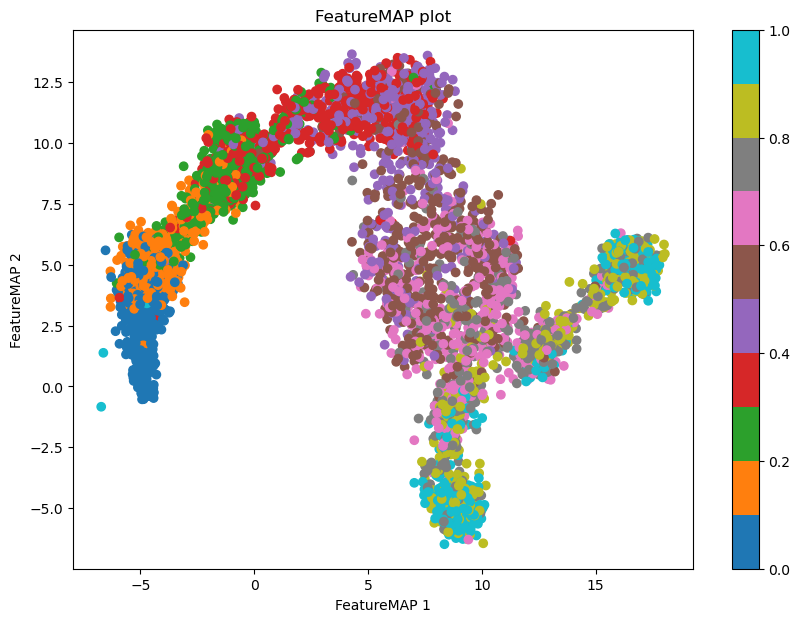

In [6]:
from featuremap import features
import importlib
importlib.reload(features)

adata = features.create_adata(X=data, emb_featuremap=emb_featuremap)

genes = ['g' + str(i) for i in range(1, 8)]
adata.var_names = genes

adata.obsm['X_svd'] = emb_svd
adata.varm['svd_vh'] = vh.T
adata.obsm['X_featmap'] = emb_featuremap.embedding_
adata.obs['pseudotime'] = data_pseudotime
adata.obs['pseudotime'] = adata.obs['pseudotime'].astype(str)   

# adata.obsm['X_umap'] = emb_umap
import scanpy as sc

import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10, 7))
plt.scatter(adata.obsm['X_featmap'][:, 0], adata.obsm['X_featmap'][:, 1], c=data_pseudotime, cmap='tab10')
plt.colorbar()
plt.xlabel('FeatureMAP 1')
plt.ylabel('FeatureMAP 2')
plt.title('FeatureMAP plot')
plt.show()



FeatureMAP variation embedding.

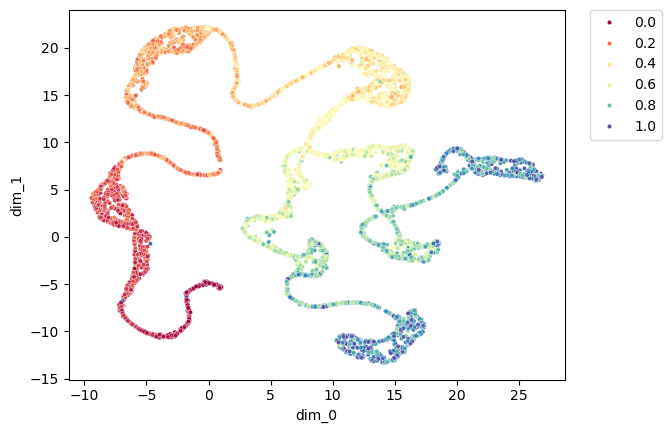

In [7]:
from featuremap import featuremap_
import importlib
importlib.reload(featuremap_)

emb_featuremap_v = featuremap_.FeatureMAP(
                    n_neighbors=30,
                    random_state=42,
                    output_variation=True,
                    n_epochs=400,
                    ).fit(emb_svd)

adata.obsm["X_featmap_v"] = emb_featuremap_v.embedding_

adata.obsm['variation_pc'] = emb_featuremap_v._featuremap_kwds['variation_pc']



import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
plt.figure(dpi=100)

embedding_df = pd.DataFrame(adata.obsm["X_featmap_v"], index=adata.obs_names, columns=['dim_0', 'dim_1'])
embedding_df['pseudotime'] = data_pseudotime
sns.scatterplot(x='dim_0',y='dim_1', hue='pseudotime', data=embedding_df, palette='Spectral', s=10)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

#### Benchmark with other DR methods

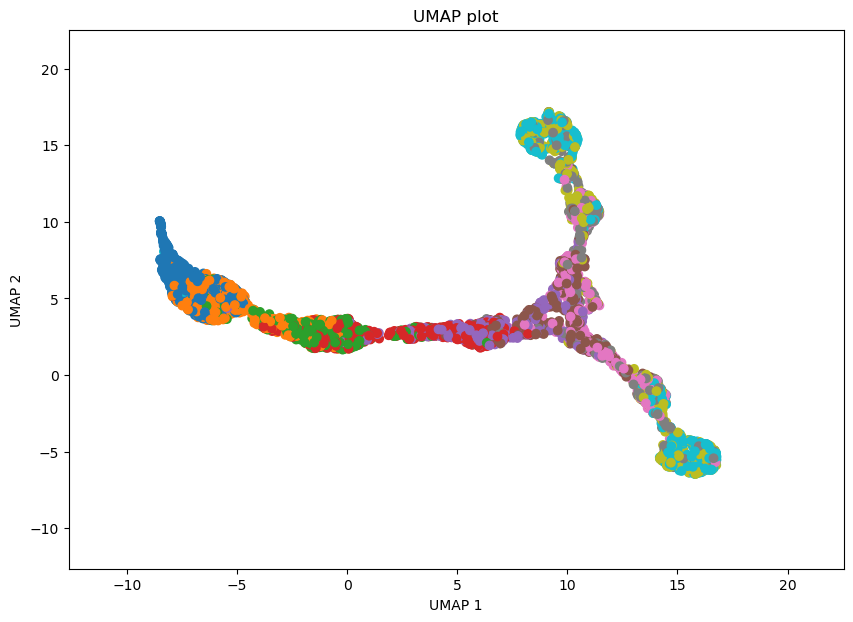

In [8]:
# UMAP plot
import umap
emb_umap = umap.UMAP().fit_transform(data)
adata.obsm['X_umap'] = emb_umap
# plot the data by UMAP
plot_func(emb_umap, data_pseudotime, 'UMAP')


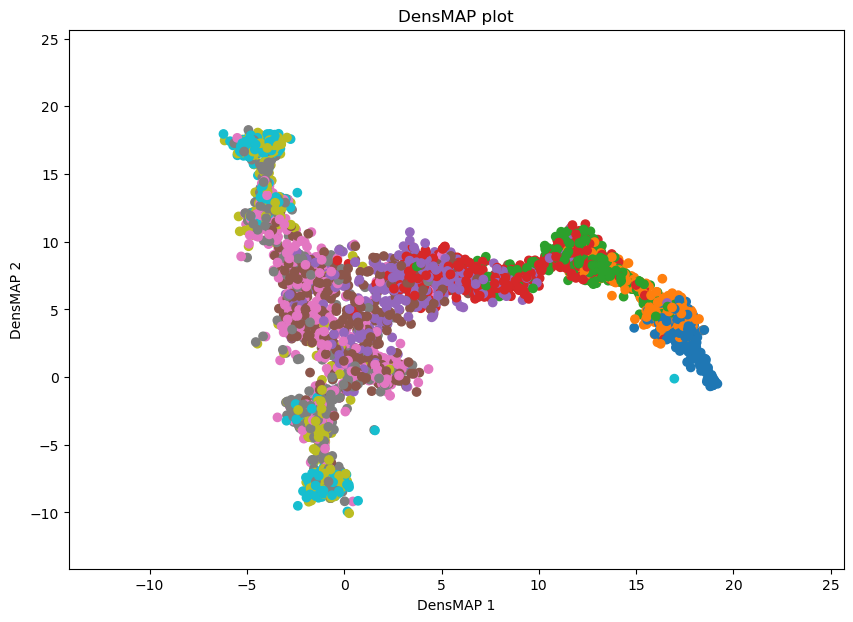

In [9]:
# DensMAP plot
import umap
emb_densmap = umap.UMAP(densmap=True).fit(data)

adata.obsm['X_densmap'] = emb_densmap.embedding_
densmap_graph = emb_densmap.graph_

# plot the data by DensMAP
plot_func(emb_densmap.embedding_, data_pseudotime, 'DensMAP')


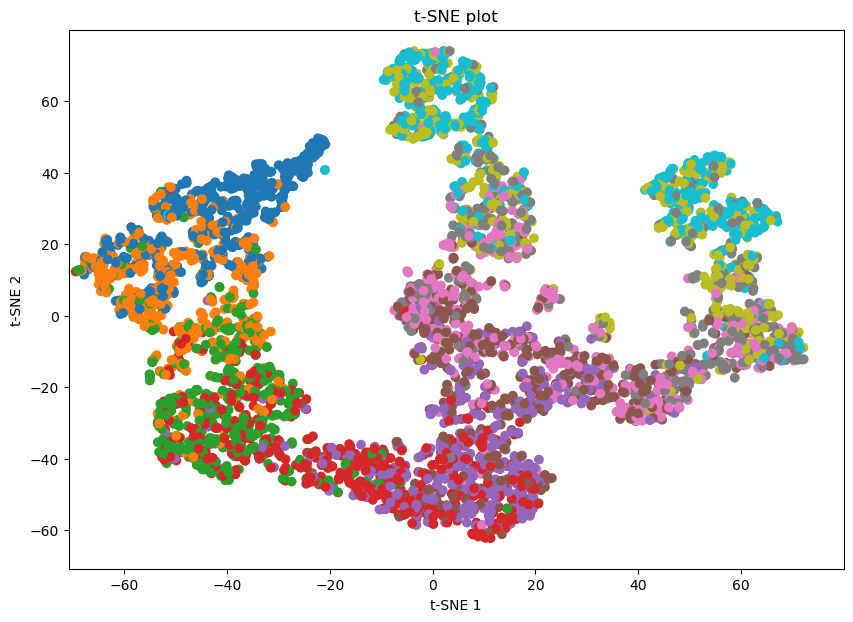

In [10]:
# plot the data by t-SNE
from sklearn.manifold import TSNE
emb_tsne = TSNE(n_components=2, random_state=42).fit_transform(data)

adata.obsm['X_tsne'] = emb_tsne

plot_func(emb_tsne, data_pseudotime, 't-SNE')

# kNN graph with k=30
from sklearn.neighbors import kneighbors_graph
k = 30
knn_graph = kneighbors_graph(data, n_neighbors=k, mode="connectivity")

tsne_graph = knn_graph


Calculating PHATE...
  Running PHATE on 5000 observations and 7 variables.
  Calculating graph and diffusion operator...
    Calculating KNN search...
    Calculated KNN search in 0.14 seconds.
    Calculating affinities...
    Calculated affinities in 0.03 seconds.
  Calculated graph and diffusion operator in 0.17 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 0.56 seconds.
    Calculating KMeans...
    Calculated KMeans in 15.38 seconds.
  Calculated landmark operator in 16.86 seconds.
  Calculating optimal t...
    Automatically selected t = 41
  Calculated optimal t in 19.13 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 31.73 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 5.60 seconds.
Calculated PHATE in 73.51 seconds.


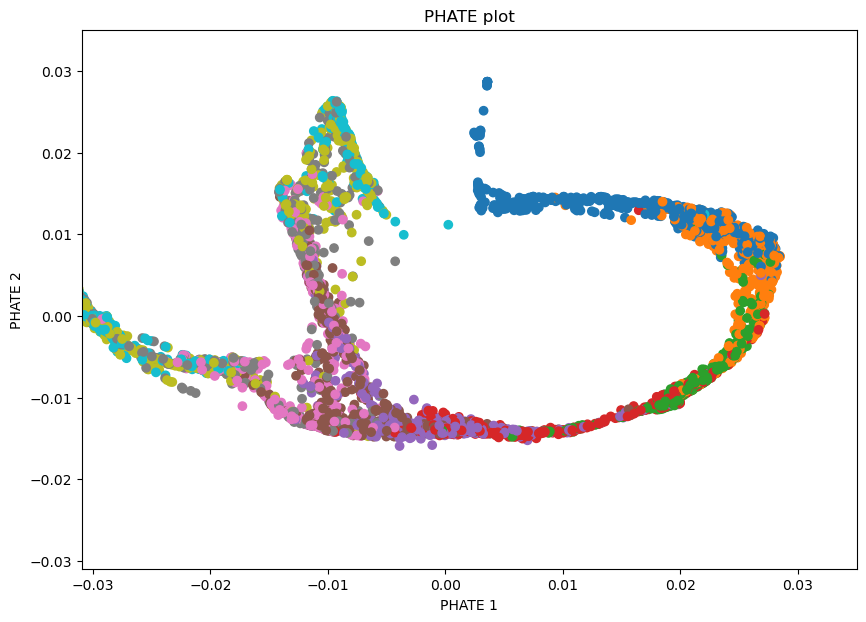

In [11]:
# plot the data by phate
import phate
phate_op = phate.PHATE()
emb_phate = phate_op.fit_transform(data)
adata.obsm['X_phate'] = emb_phate

plot_func(emb_phate, data_pseudotime, 'PHATE')



Get the PHATE graph for curvature and betweenness centrality calculation.

In [12]:

emb_phate_obj = phate_op.fit(data)
phate_graph = emb_phate_obj.graph.to_igraph()
# number of nodes
print(phate_graph.vcount())

# to networkx
phate_graph_nx = phate_graph.to_networkx()


Running PHATE on 5000 observations and 7 variables.
Calculating graph and diffusion operator...
  Calculating KNN search...
  Calculated KNN search in 0.13 seconds.
  Calculating affinities...
  Calculated affinities in 0.02 seconds.
Calculated graph and diffusion operator in 0.16 seconds.
Calculating landmark operator...
  Calculating SVD...
  Calculated SVD in 0.55 seconds.
  Calculating KMeans...
  Calculated KMeans in 12.35 seconds.
Calculated landmark operator in 13.74 seconds.
5000


Compute gene variation for each feature.

In [13]:
importlib.reload(featuremap_)
from featuremap.features import feature_variation, feature_variation_embedding
feature_variation(adata, threshold=0.9)

k is 3
Start matrix multiplication
Finish matrix multiplication in 0.0009179115295410156
Finish norm calculation in 0.0007960796356201172


Density plot shows the number of clusters by density peaks.

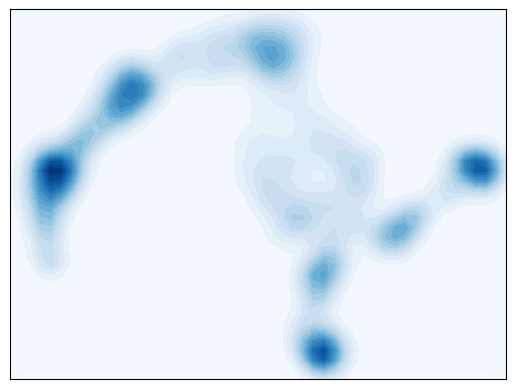

<Figure size 640x480 with 0 Axes>

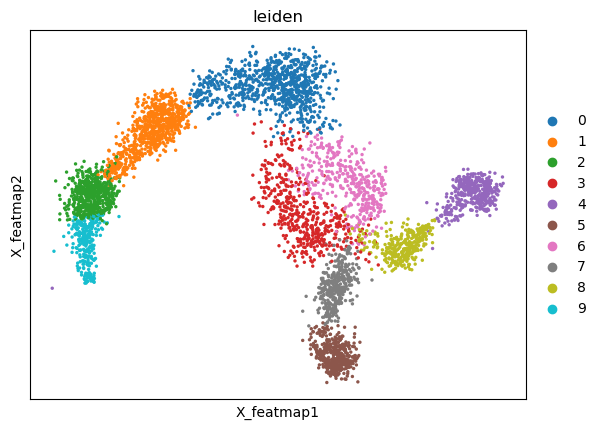

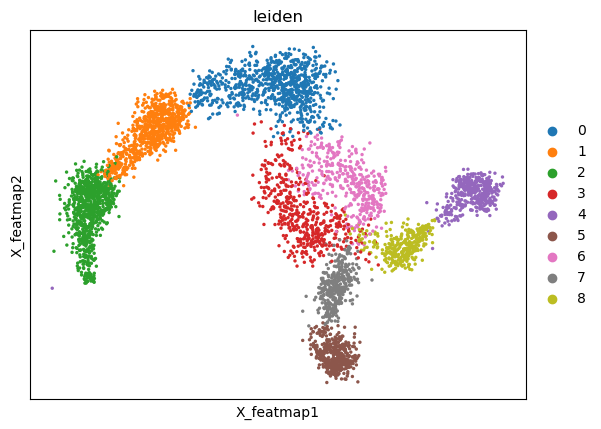

In [14]:
##################################
# Contour plot to show the density
######################################
from featuremap import core_transition_states
import importlib
importlib.reload(core_transition_states)

from featuremap.core_transition_states import plot_density
plot_density(adata)


# leiden clustering
import scanpy as sc
sc.pp.neighbors(adata, n_neighbors=15)
sc.tl.leiden(adata, resolution=0.5)
sc.pl.embedding(adata, basis='X_featmap', color='leiden',  )

# Optional: merge small clusters into one based on the density
# merge leiden clusters '9' and '2' into '2'
adata.obs['leiden'] = adata.obs['leiden'].replace('9', '2')
sc.pl.embedding(adata, basis='X_featmap', color='leiden',  )



### Transition and core states identification by density, curvature and betweenness centrality.

Use density to define transition and core states.

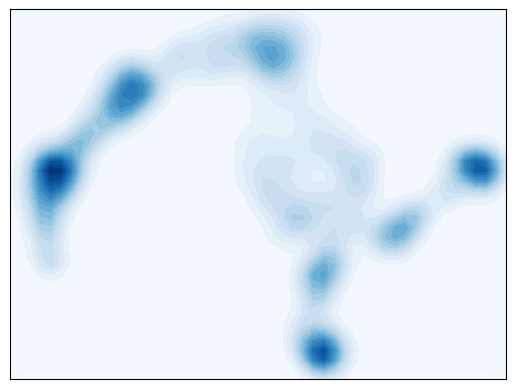

<Figure size 640x480 with 0 Axes>

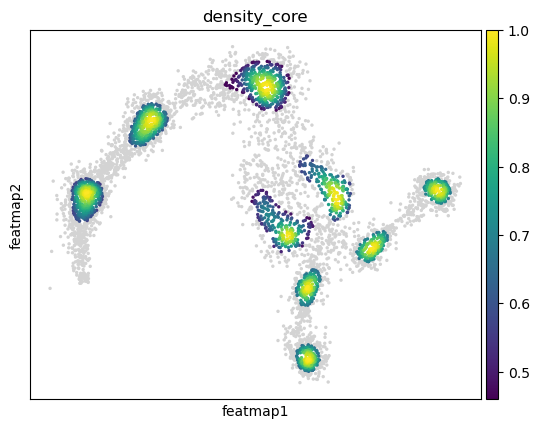

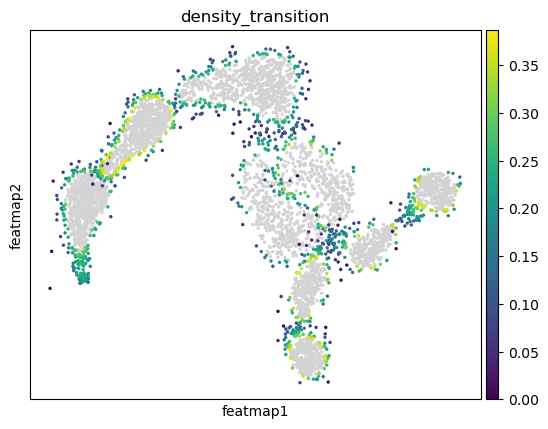

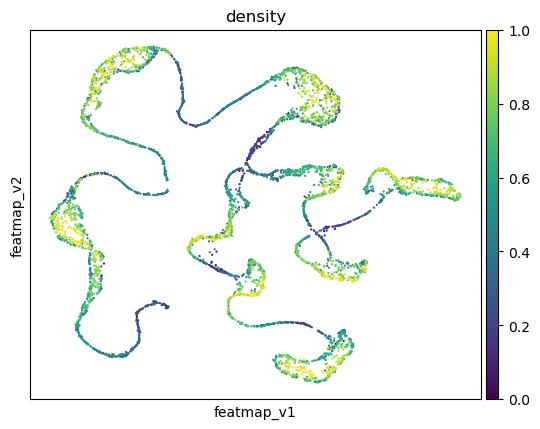

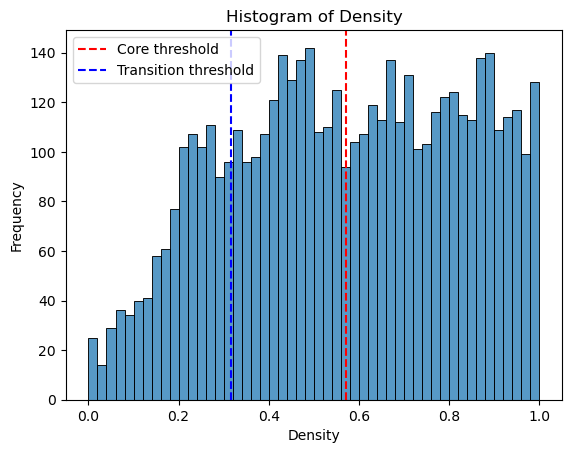

In [15]:
##################################
# Contour plot to show the density
######################################
from featuremap import core_transition_states
import importlib
importlib.reload(core_transition_states)

from featuremap.core_transition_states import plot_density
plot_density(adata)


#%%
#######################################################
# Compute core-states based on clusters
#########################################################
quantile_core = 0.5
quantile_trans = 0.2


from featuremap.core_transition_states import compute_density
compute_density(adata, quantile_core=quantile_core, quantile_trans=quantile_trans)

# import scanpy as sc
# sc.pl.embedding(adata, basis='X_featmap_v', color='core_trans_states',  )
sc.pl.embedding(adata, 'featmap_v',legend_fontsize=6, s=10, legend_loc='on data', color='density')

# plot histogram of density
import seaborn as sns
import matplotlib.pyplot as plt

density = adata.obs['density']

plt.figure(dpi=100)
sns.histplot(density, bins=50)
plt.xlabel('Density')
plt.ylabel('Frequency')
plt.title('Histogram of Density')
threshold_core = density.quantile(quantile_core)
plt.axvline(threshold_core, color='red', linestyle='--', label='Core threshold')

threshold_trans = density.quantile(quantile_trans)
plt.axvline(threshold_trans, color='blue', linestyle='--', label='Transition threshold')
plt.legend()

plt.show()




Use curvature to define transition and core states.

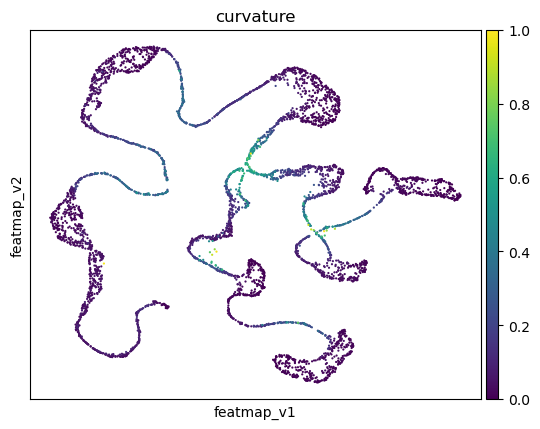

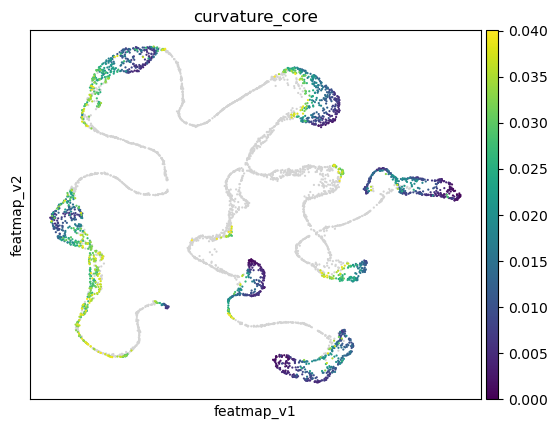

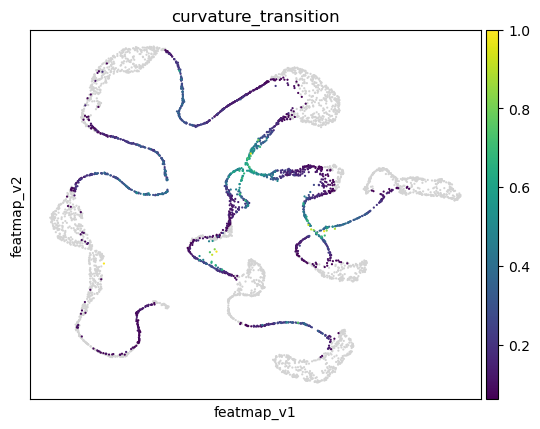

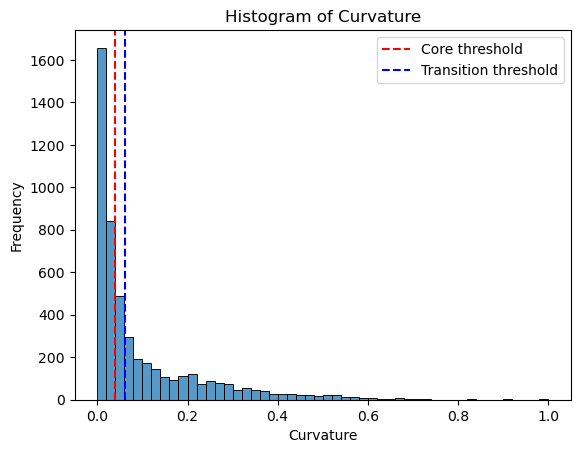

In [16]:
from featuremap import core_transition_states
import importlib
importlib.reload(core_transition_states)

quantile_core = 0.5
quantile_trans = 0.6
core_transition_states.compute_curvature(adata, emb_featuremap, quantile_core=quantile_core, quantile_trans=quantile_trans)

# plot histogram of curvature
import seaborn as sns
import matplotlib.pyplot as plt

curvature = adata.obs['curvature']

plt.figure(dpi=100)
sns.histplot(curvature, bins=50)
plt.xlabel('Curvature')
plt.ylabel('Frequency')
plt.title('Histogram of Curvature')
threshold_core = curvature.quantile(quantile_core)
plt.axvline(threshold_core, color='red', linestyle='--', label=f'Core threshold')

threshold_trans = curvature.quantile(quantile_trans)
plt.axvline(threshold_trans, color='blue', linestyle='--', label=f'Transition threshold')
plt.legend()

plt.show()


Use betweeness centrality to define transition states.

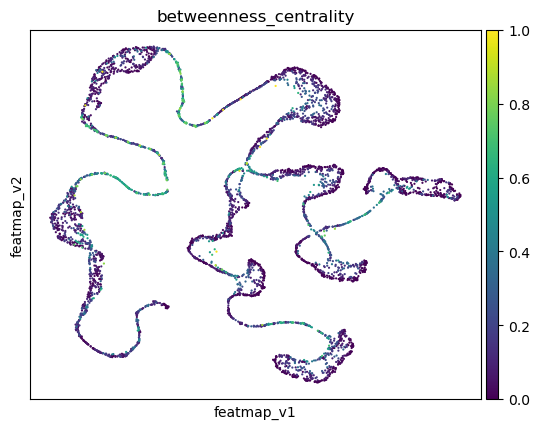

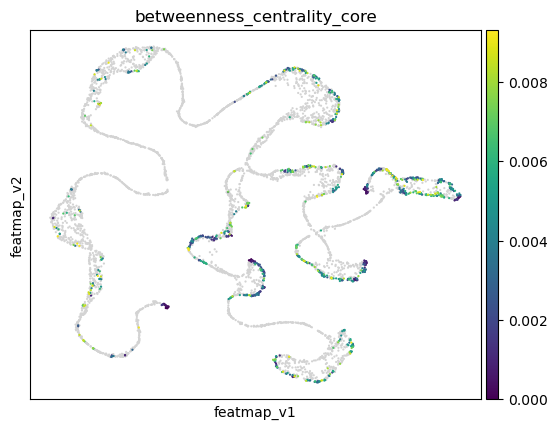

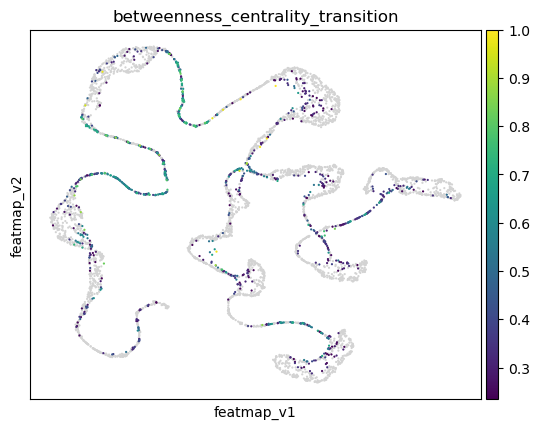

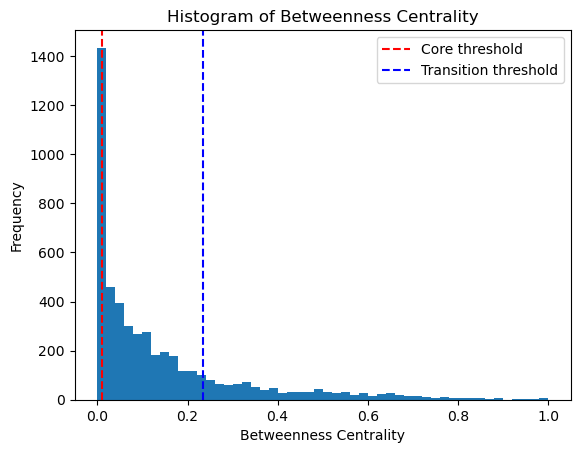

In [17]:
from featuremap import core_transition_states
import importlib
importlib.reload(core_transition_states)

quantile_trans = 0.8
quantile_core = 0.2


core_transition_states.compute_betweenness_centrality(adata, emb_featuremap, quantile_core=quantile_core, quantile_trans=quantile_trans)

betweenness_centrality = adata.obs['betweenness_centrality'].copy()
plt.hist(betweenness_centrality, bins=50)

threshold_core = betweenness_centrality.quantile(quantile_core)
plt.axvline(threshold_core, color='red', linestyle='--', label=f'Core threshold')

threshold_trans = betweenness_centrality.quantile(quantile_trans)
plt.axvline(threshold_trans, color='blue', linestyle='--', label=f'Transition threshold')  
plt.legend()

plt.xlabel('Betweenness Centrality')
plt.ylabel('Frequency')
plt.title('Histogram of Betweenness Centrality')

plt.show()

Visualize the transition and core states.

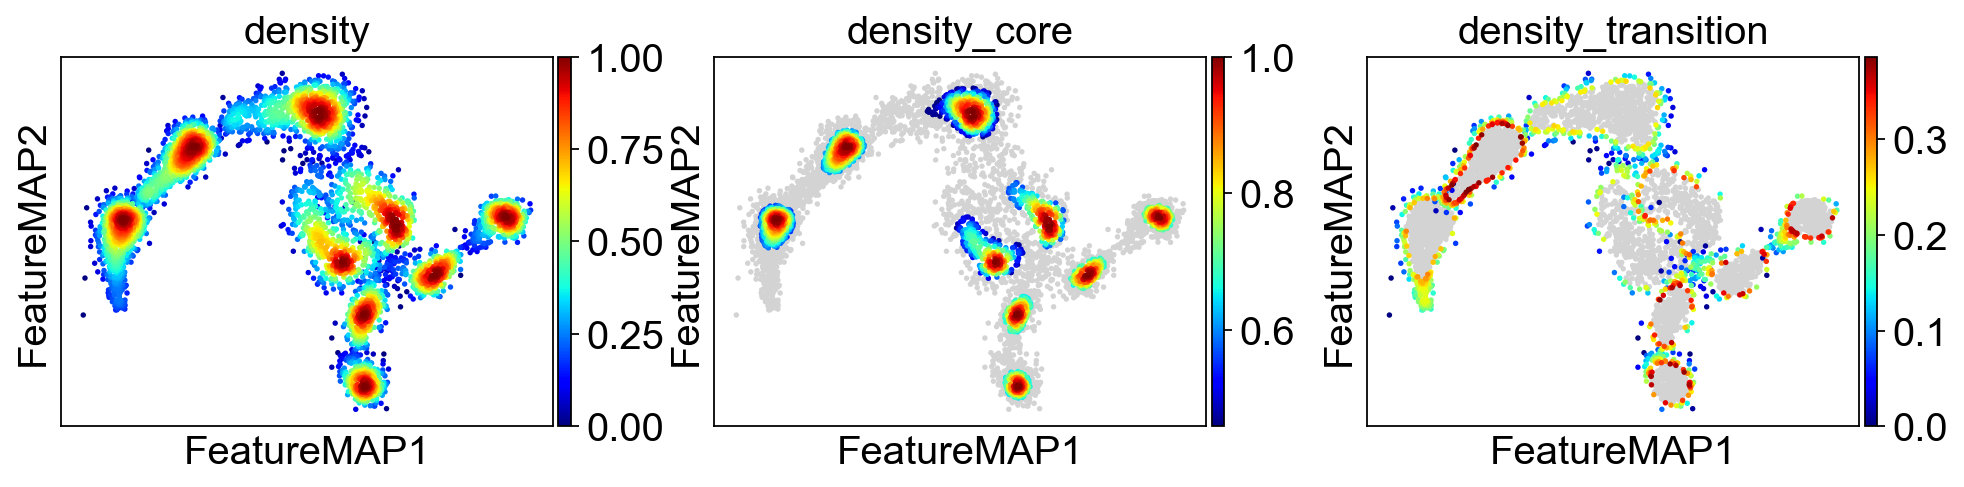

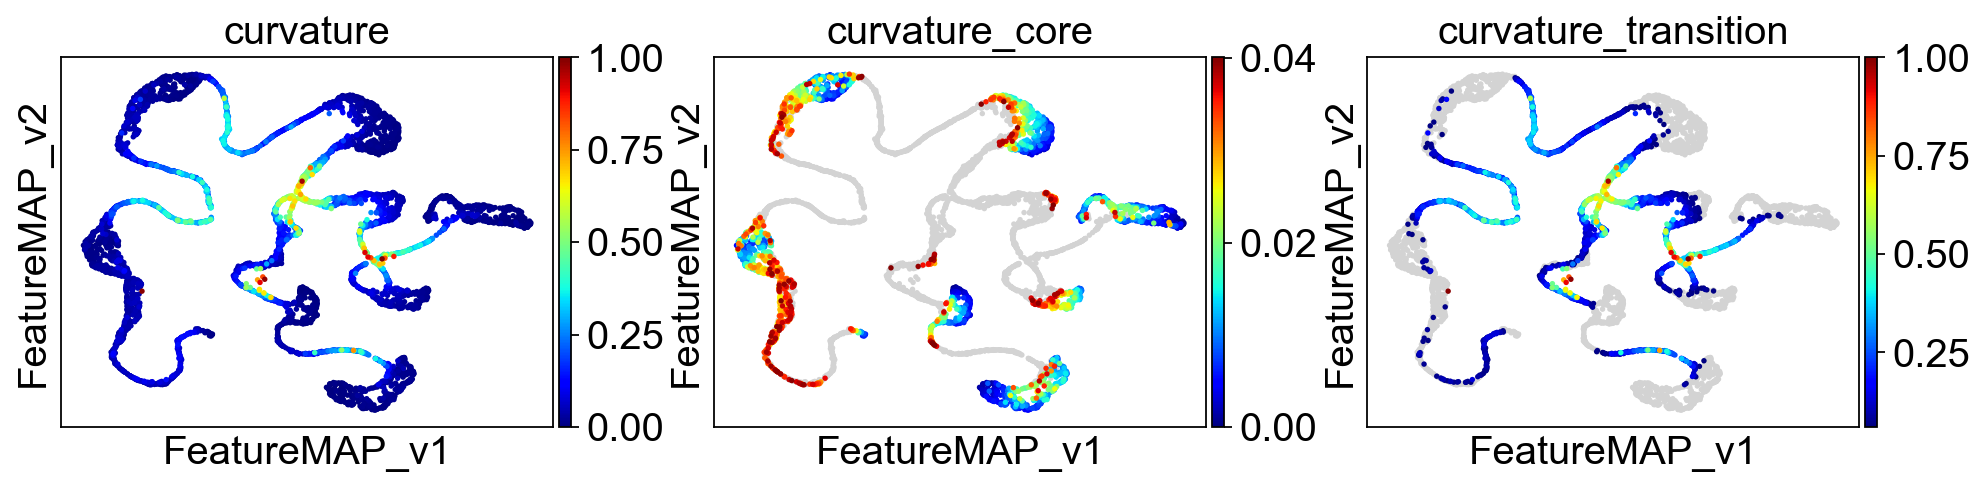

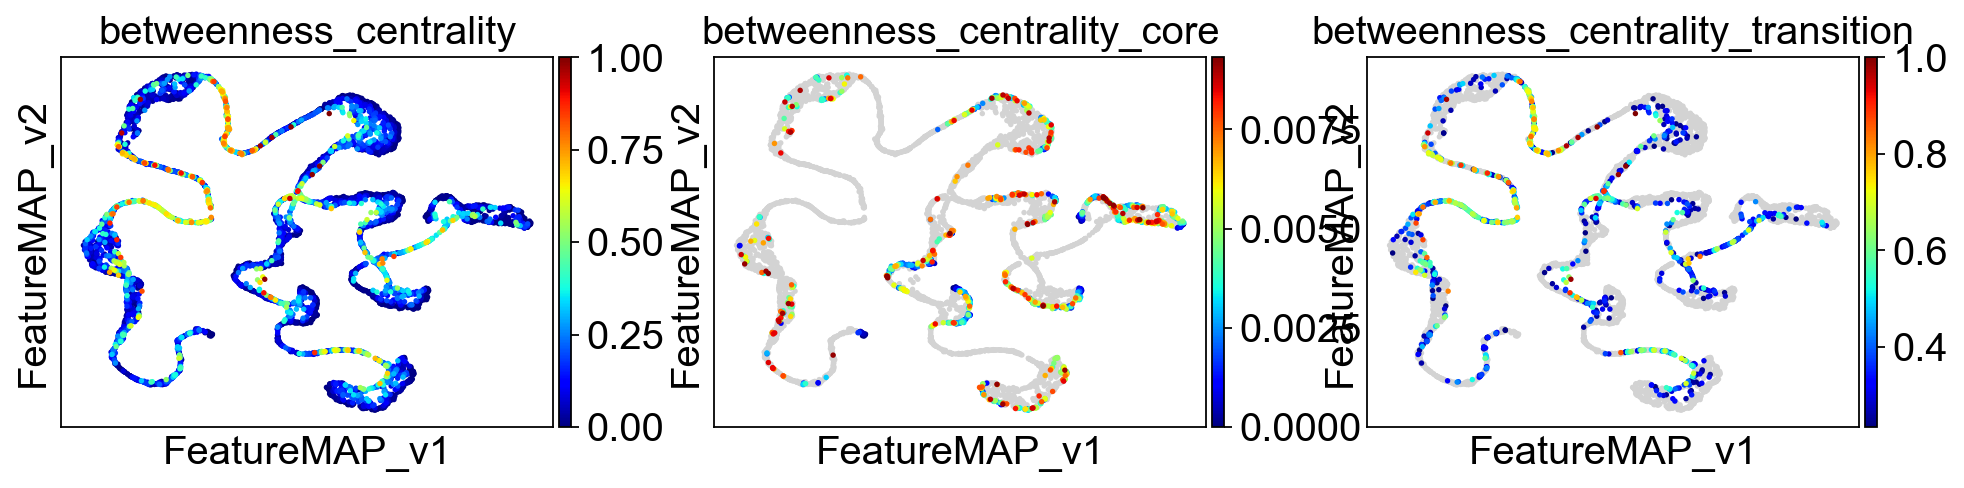

In [18]:
adata.obsm['X_FeatureMAP'] = adata.obsm['X_featmap']
adata.obsm['X_FeatureMAP_v'] = adata.obsm['X_featmap_v']

# set figure size
sc.set_figure_params(figsize=(4, 3),fontsize=18)
sc.pl.embedding(adata, basis='FeatureMAP', color=['density', 'density_core', 'density_transition'], cmap='jet', save='_linear_density.png') 
sc.pl.embedding(adata, basis='FeatureMAP_v', color=['curvature', 'curvature_core', 'curvature_transition'], cmap='jet', save='_linear_curvature.png')
sc.pl.embedding(adata, basis='FeatureMAP_v', color=['betweenness_centrality', 'betweenness_centrality_core', 'betweenness_centrality_transition'], 
                cmap='jet',save='_linear_betweenness_centrality.png') 


Union the results of transition and core states by density, curvature and betweenness centrality.

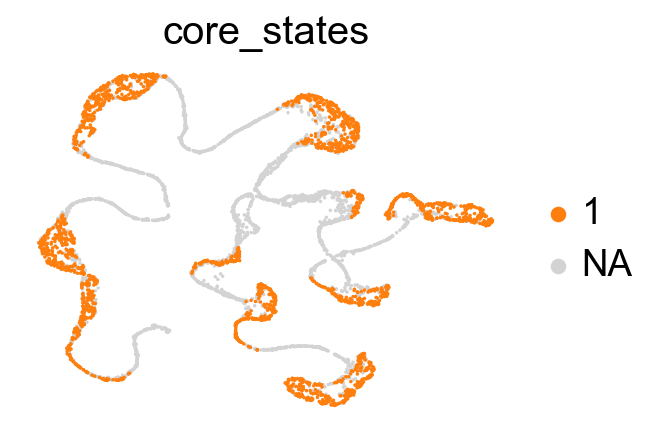

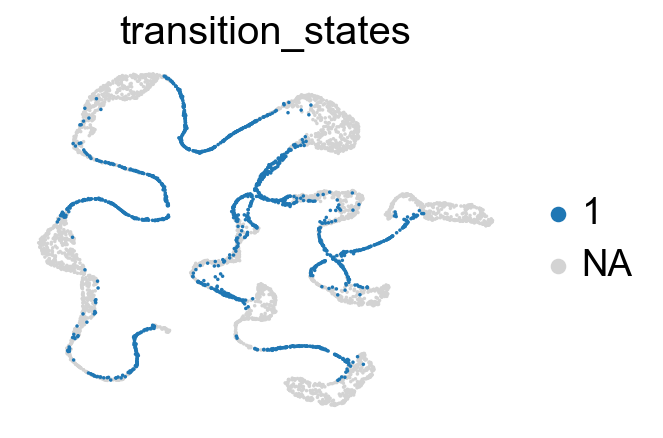

In [19]:
from featuremap import core_transition_states
core_transition_states.plot_core_transition_states(adata)

Compute the cluster state labels based on the percentage of core_states and transition_states for each cluster.

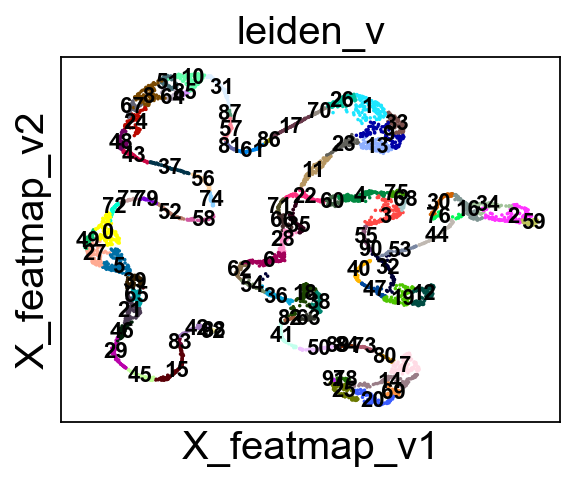

In [20]:
import anndata as ad
adata_var = ad.AnnData(X=adata.obsm['variation_pc'], obs=adata.obs)
adata_var.obsm['X_featmap_v'] = adata.obsm['X_featmap_v']
# adata_var.obs['clusters'] = adata.obs['clusters']

# leiiden clustering on variation embedding
sc.pp.pca(adata_var)
sc.pp.neighbors(adata_var, n_neighbors=5,)
sc.tl.leiden(adata_var, resolution=1)

adata.obs['leiden_v'] = adata_var.obs['leiden']

sc.pl.embedding(adata, basis='X_featmap_v', color='leiden_v', legend_loc='on data', s=10, legend_fontsize=10)

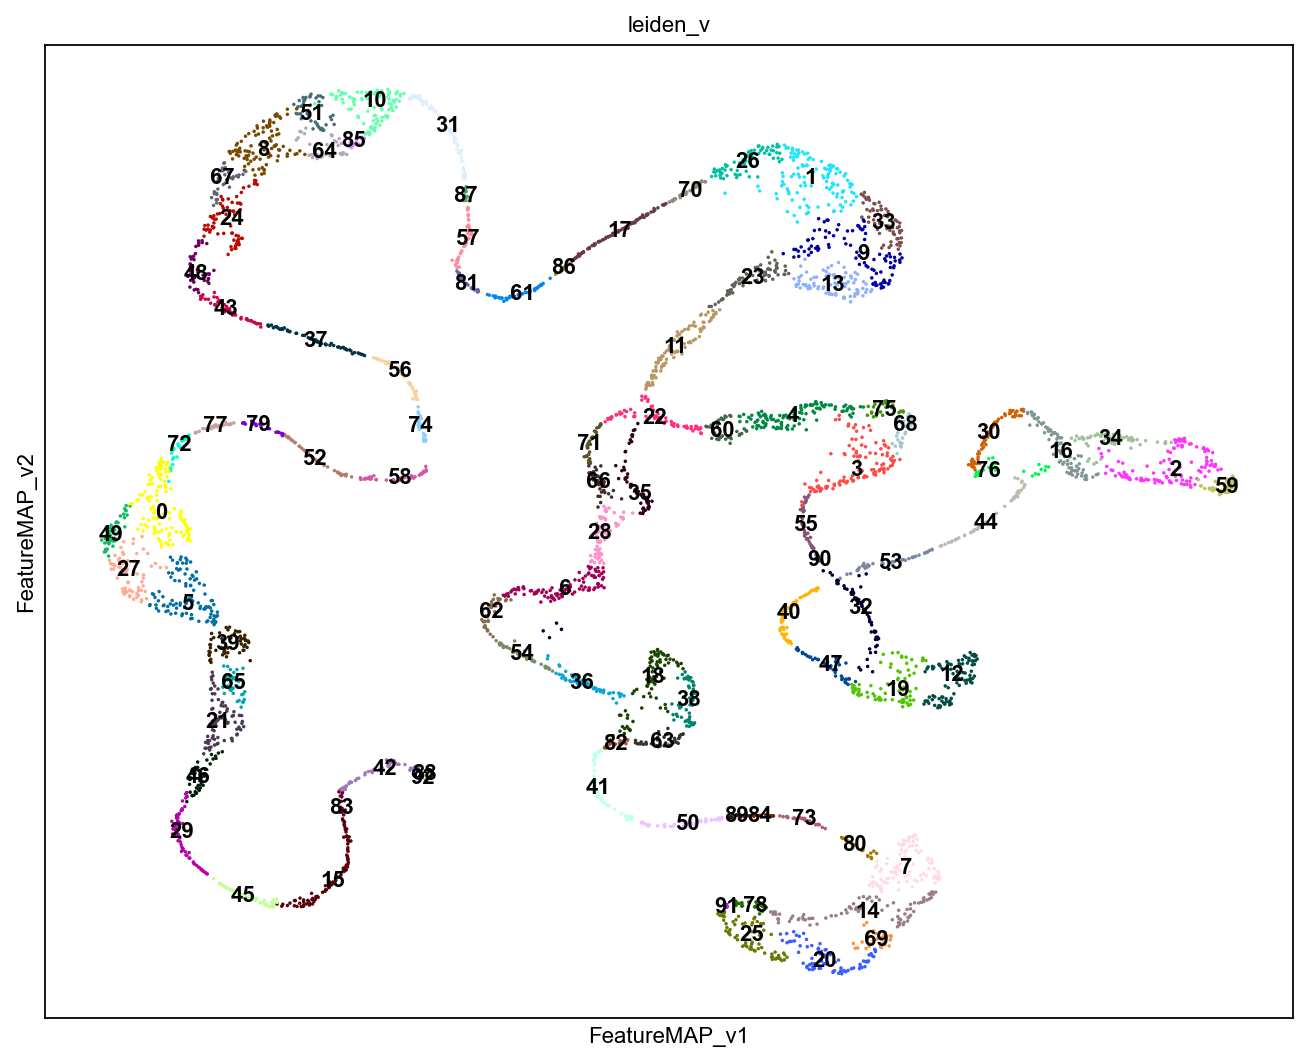

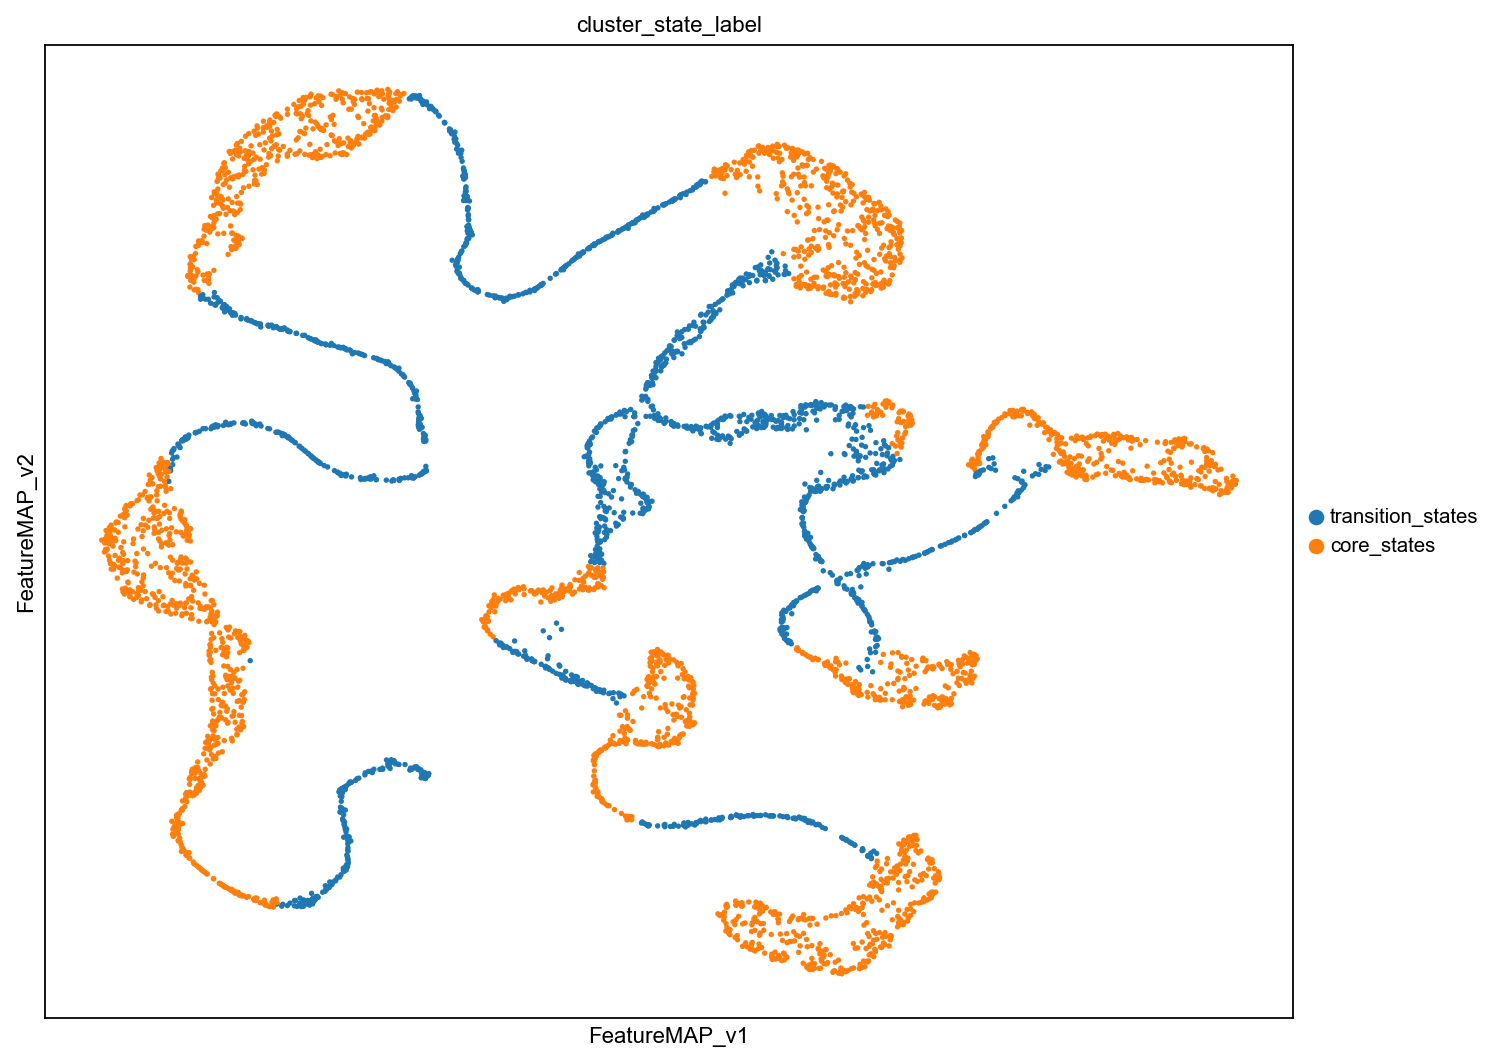

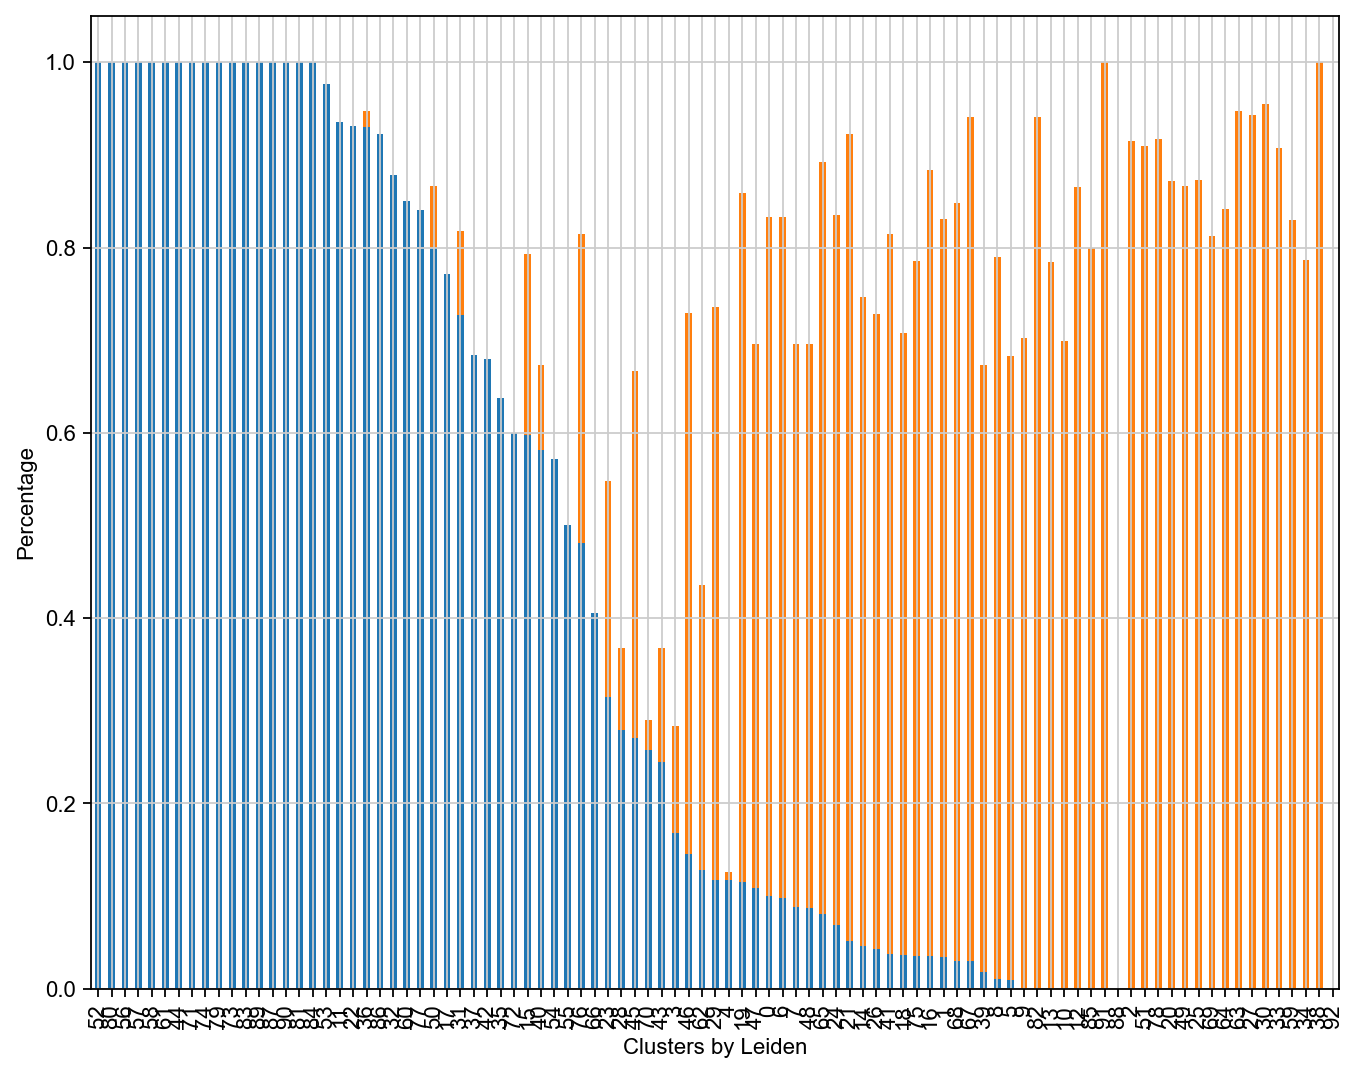

In [21]:
from featuremap import core_transition_states

# plot the leiden clusters
sc.set_figure_params(figsize=(10, 8),fontsize=10)
sc.pl.embedding(adata, basis='FeatureMAP_v', color='leiden_v', cmap='viridis',  legend_loc='on data', s=10)

core_transition_states.compute_cluster_state_labels(adata)

### Benchmark FeatureMAP with others to visualize transition and core states.

Visualize transtion and core states by different methods.

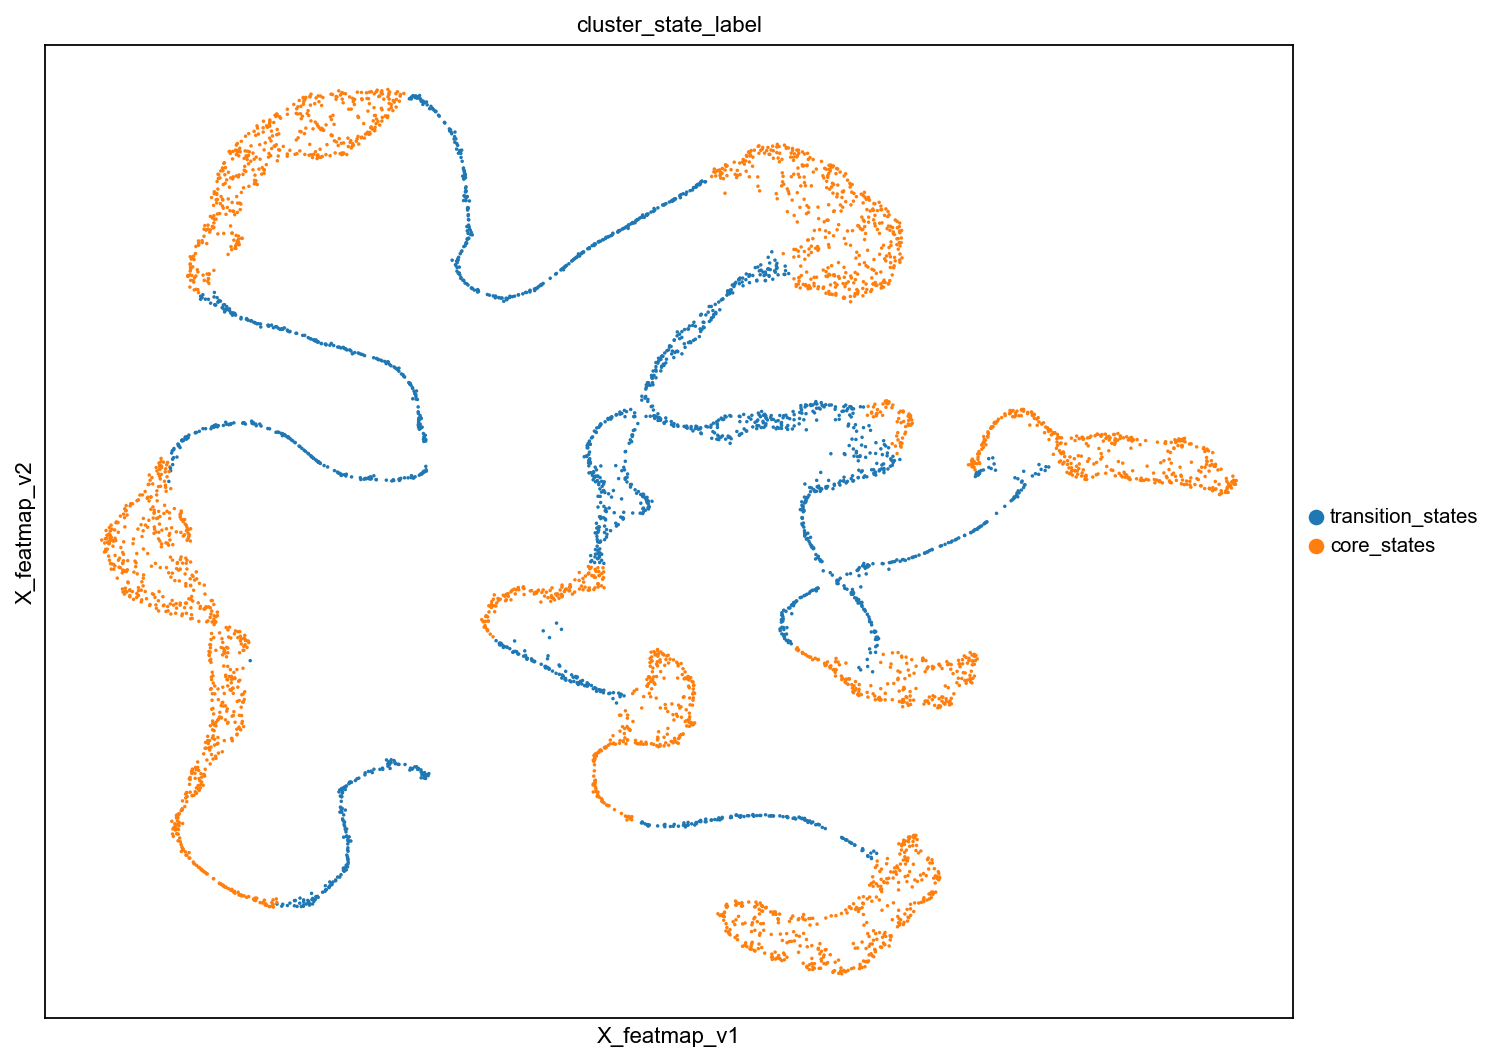

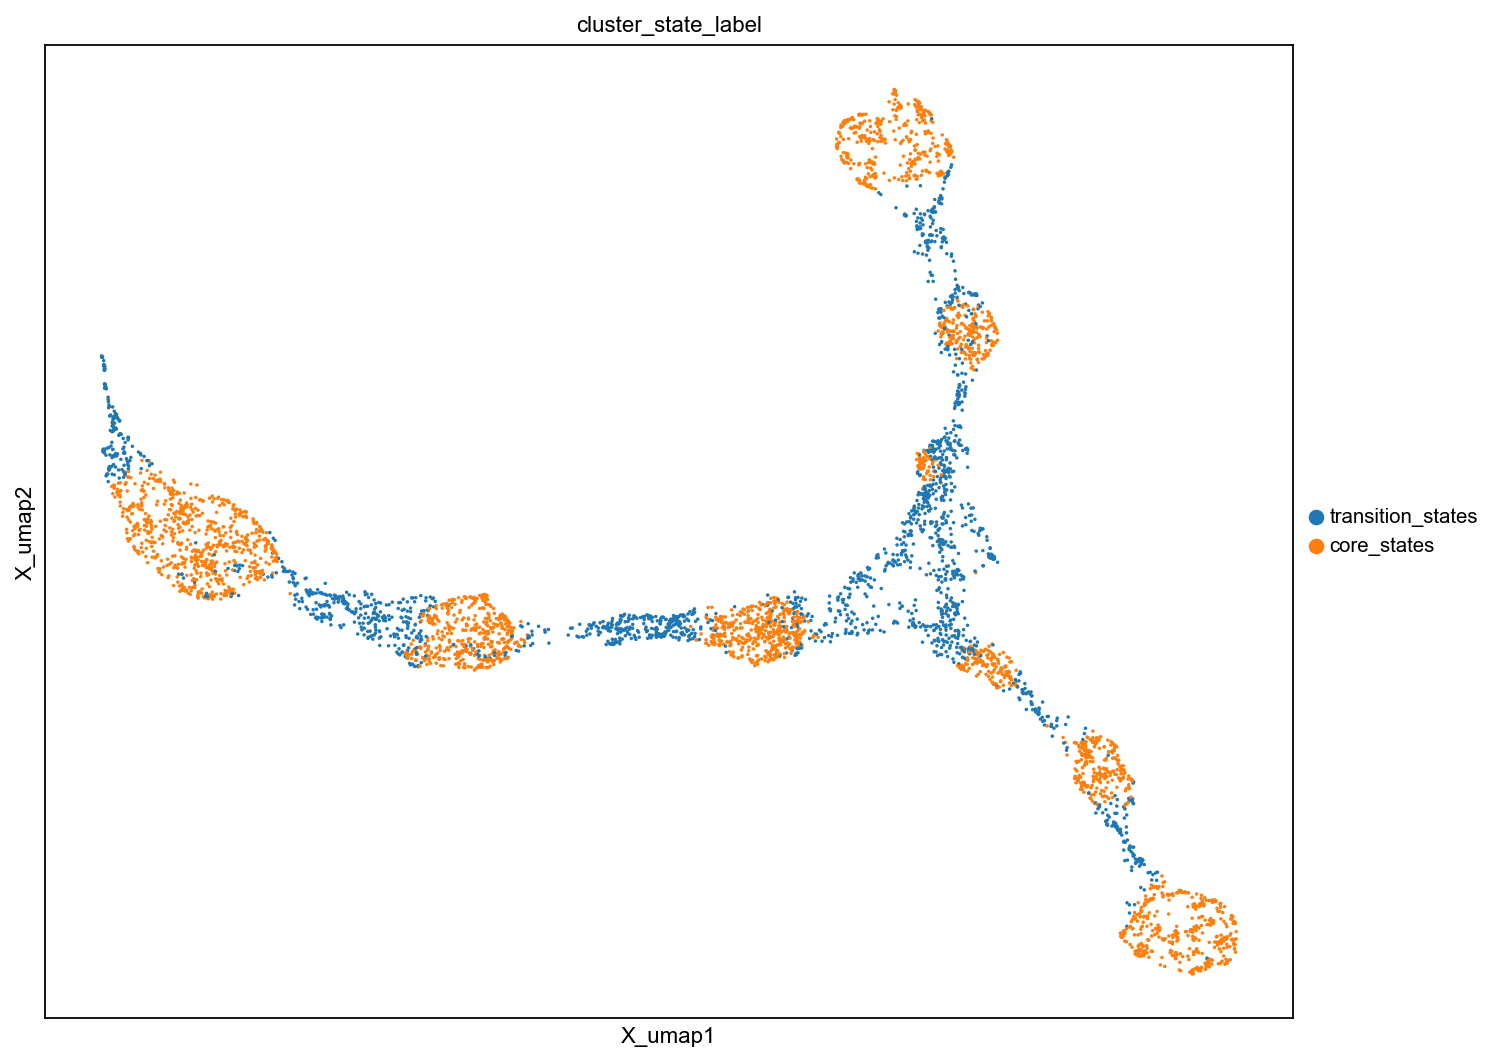

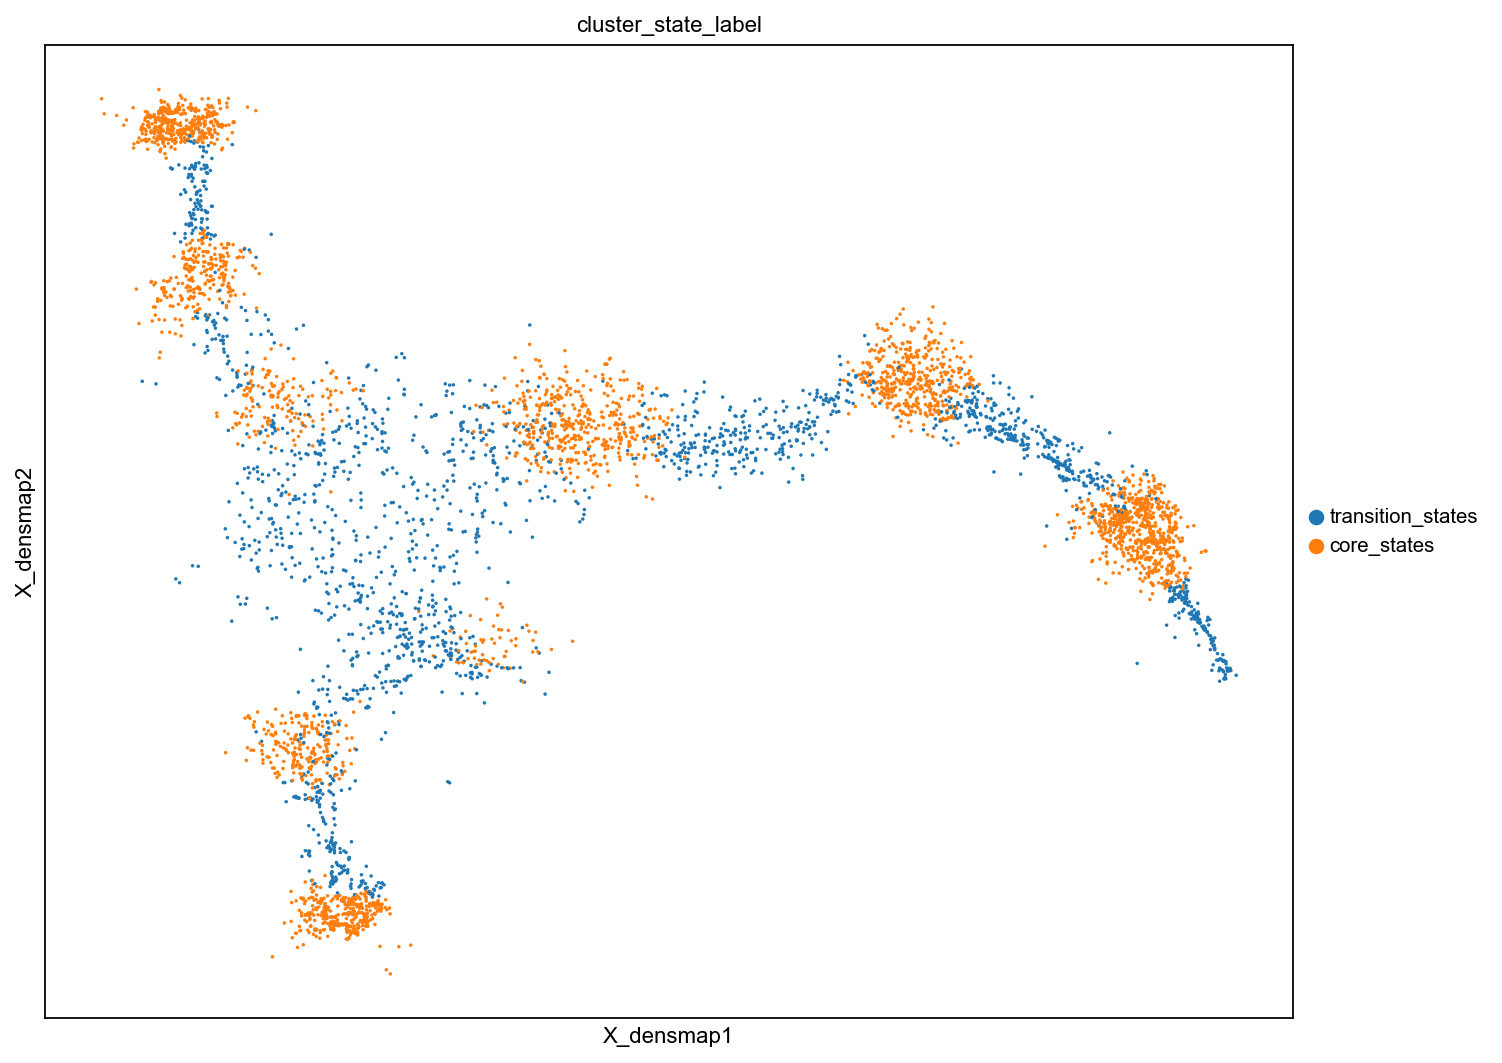

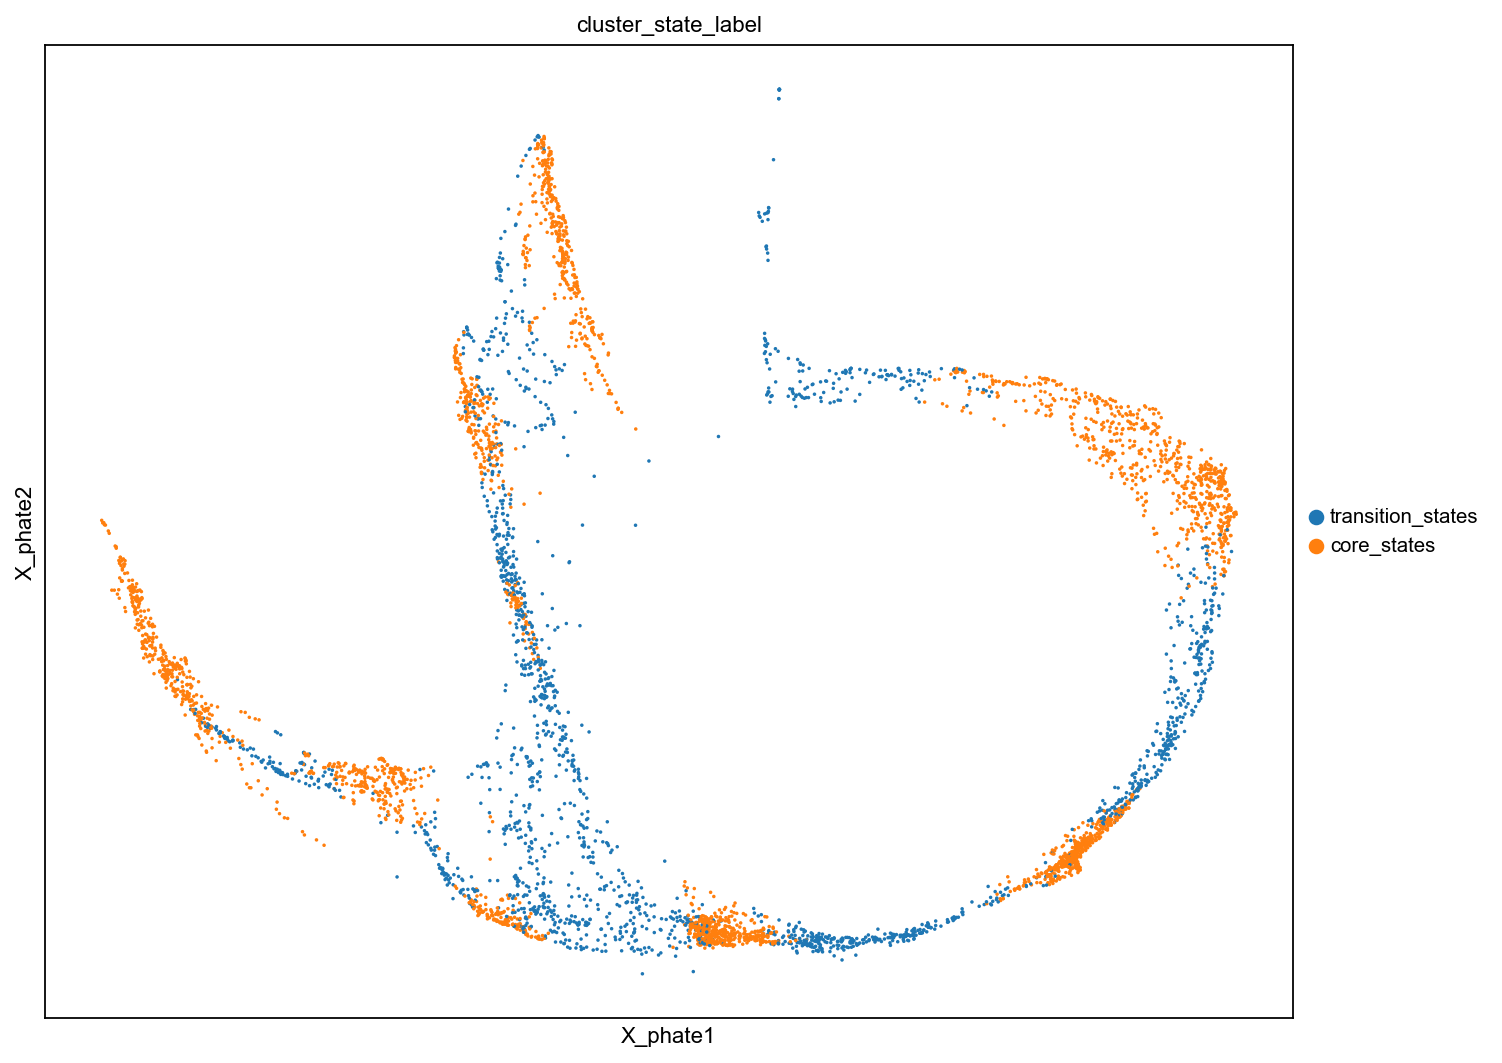

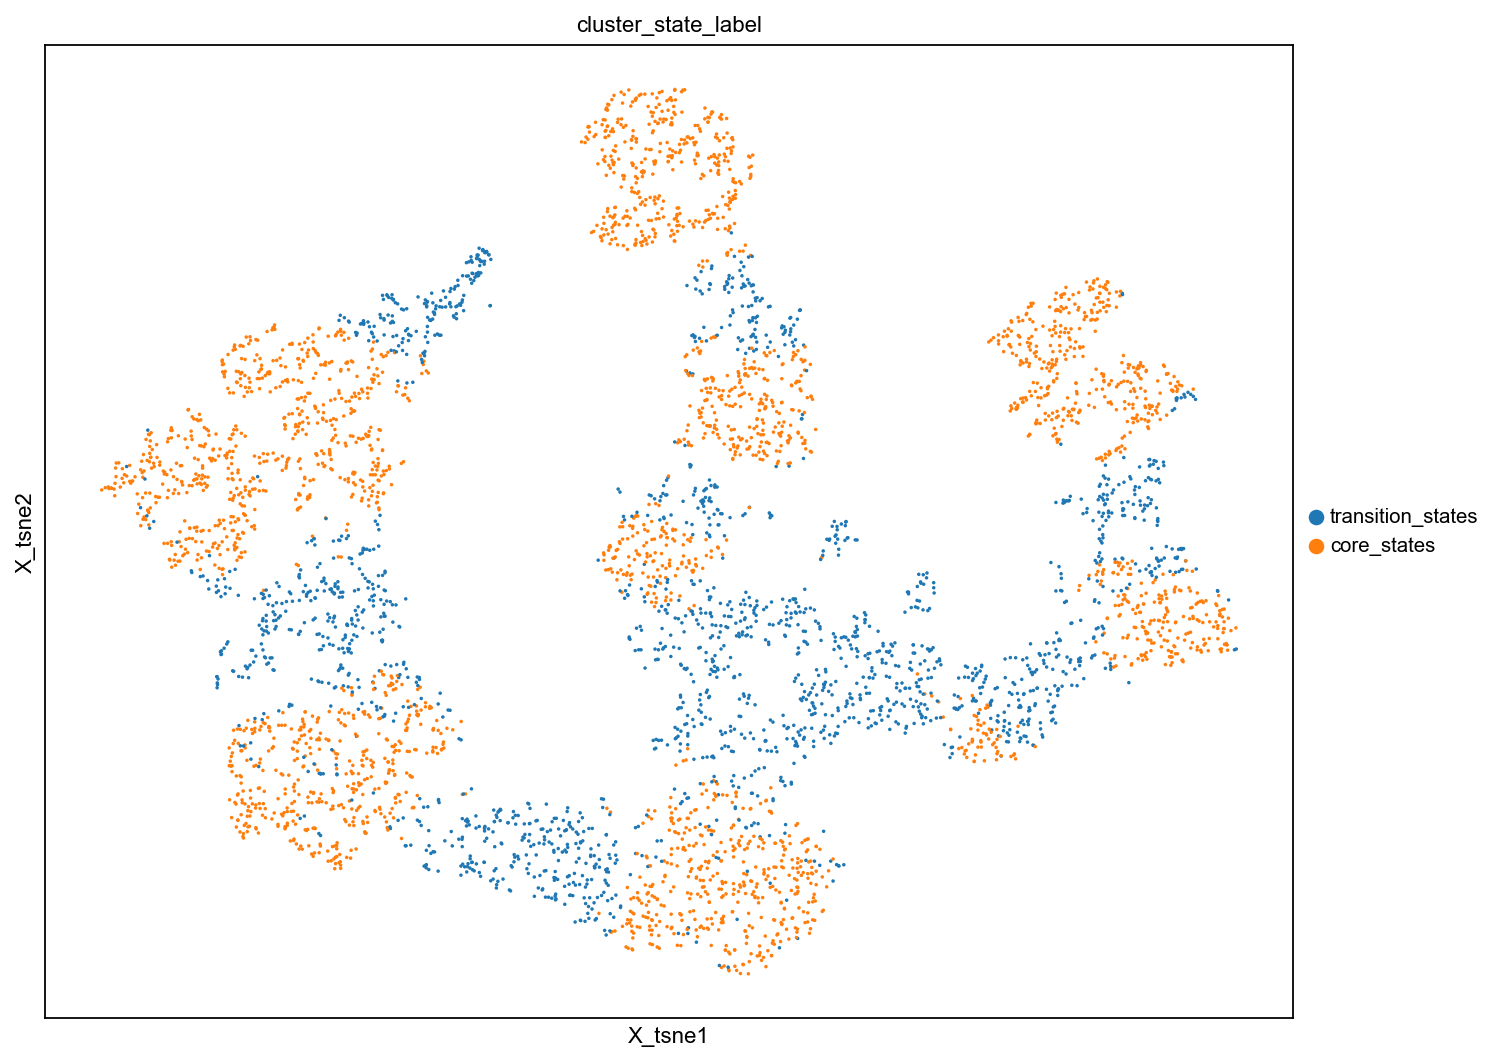

In [22]:
# visualize cluster_state_label in UMAP, DensMAP, PHATE, t-SNE, PCA
sc.pl.embedding(adata, basis='X_featmap_v', color='cluster_state_label', cmap='Blues_r', s=10, )
sc.pl.embedding(adata, basis='X_umap', color='cluster_state_label', cmap='Blues_r', s=10, )
sc.pl.embedding(adata, basis='X_densmap', color='cluster_state_label', cmap='Blues_r', s=10, )
sc.pl.embedding(adata, basis='X_phate', color='cluster_state_label', cmap='Blues_r', s=10, )
sc.pl.embedding(adata, basis='X_tsne', color='cluster_state_label', cmap='Blues_r', s=10, )


 Compare the clustering coefficient in clustersing by expression and variation space

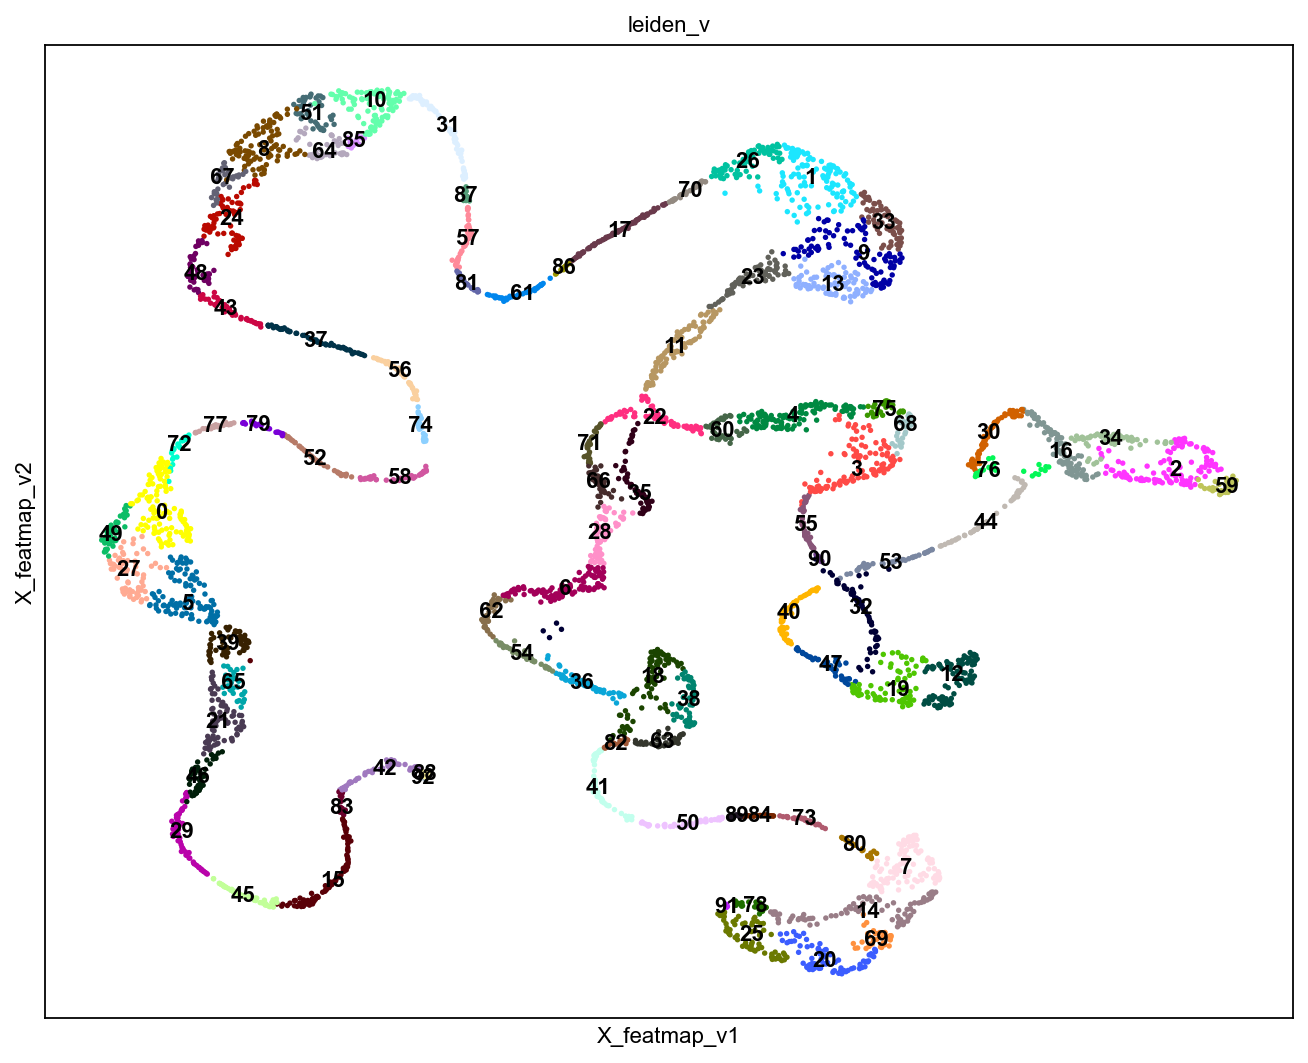

Computing the weighted clustering coefficients...
ANOVA: f_stat: 131.35995438614765, p_val: 3.266876521647282e-58


<Figure size 400x300 with 0 Axes>

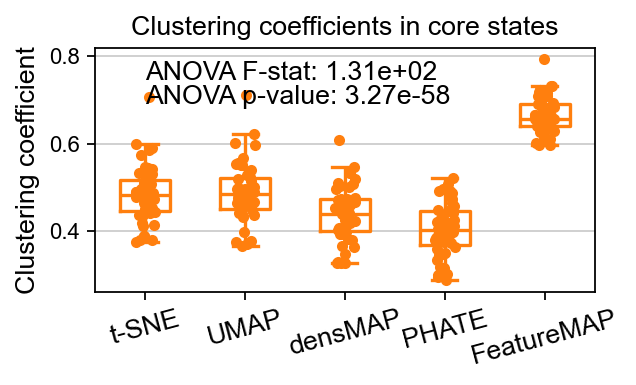

ANOVA: f_stat: 76.71507530641118, p_val: 6.126912474001551e-41


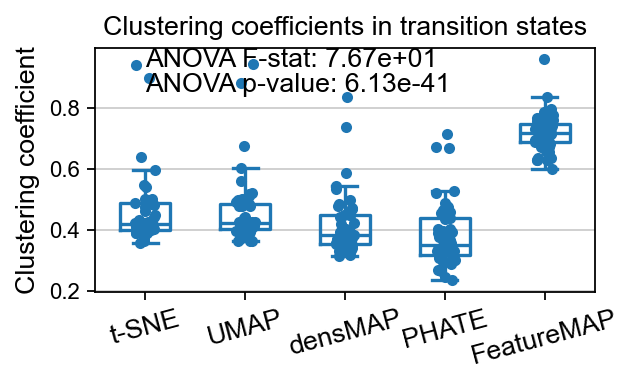

In [23]:
from featuremap import core_transition_states

import importlib
importlib.reload(core_transition_states)

core_transition_states.compute_and_plot_clustering_coefficients(adata, emb_featuremap, emb_featuremap_v, phate_graph_nx, tsne_graph, densmap_graph)


### DGV analysis reveal the true regualtion genes

DPT pseudotime.

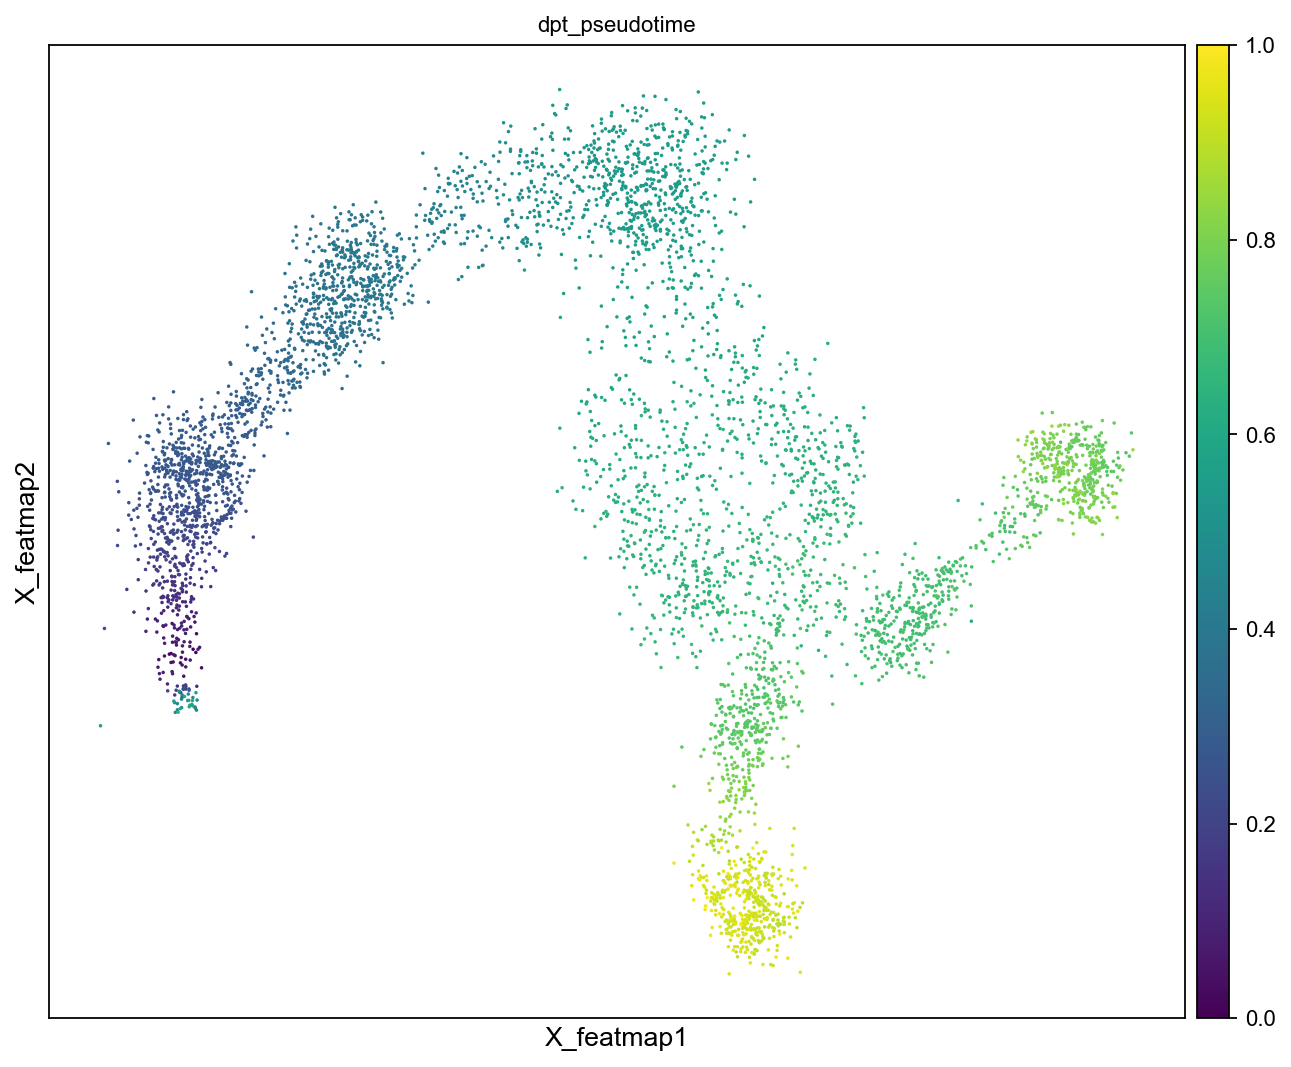

In [24]:
from featuremap import features
import importlib
importlib.reload(features)

importlib.reload(featuremap_)

# DPT pseudotime
# set root
start_point_index = np.random.choice(np.where(data_pseudotime < 0.01)[0])

adata.uns['iroot'] = start_point_index

sc.pp.neighbors(adata, n_neighbors=10)
sc.tl.diffmap(adata)
sc.tl.dpt(adata)

sc.pl.embedding(adata, basis='X_featmap', color='dpt_pseudotime', cmap='viridis', s=10)


Conventional DGE analysis on gene expression clusters fails to detect the regualtory gene.

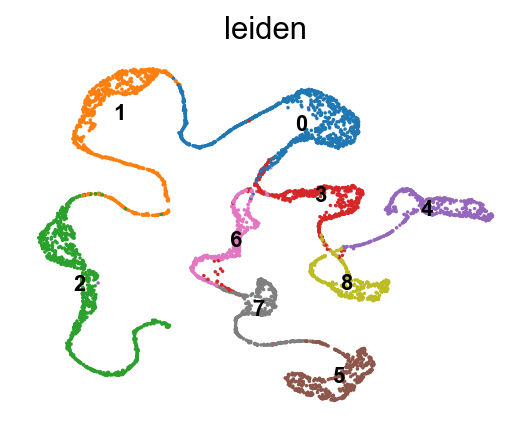

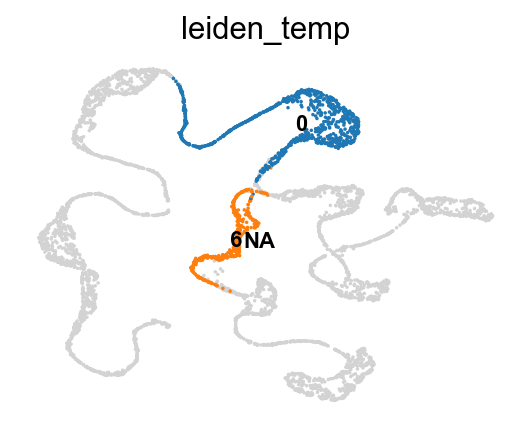

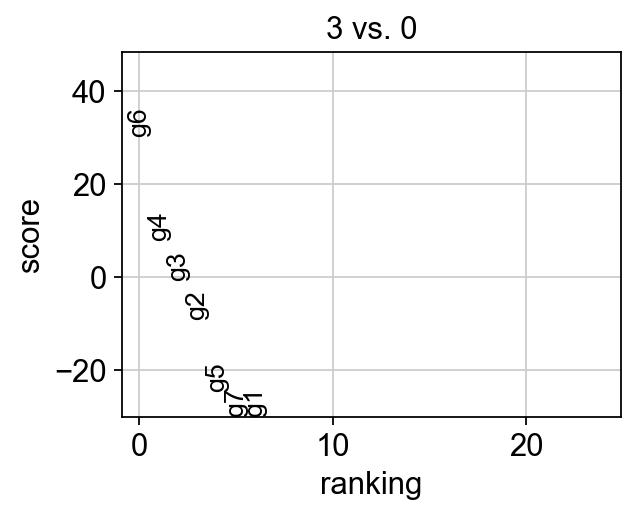

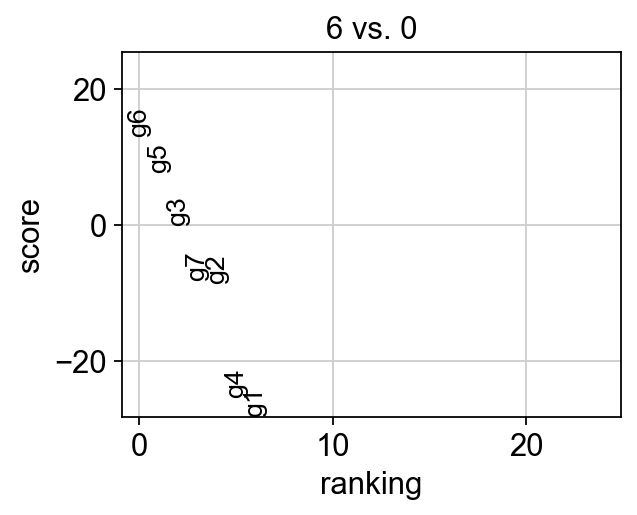

In [25]:

sc.set_figure_params(dpi=80, figsize=(4, 3), frameon=False )

# plot leiden clusters
sc.pl.embedding(adata, basis='X_featmap_v', color='leiden', legend_loc='on data', s=10, legend_fontsize=10)

data_clusters = adata.obs['leiden']

# Set all as NaN besides the clusters 0 and 3

import numpy as np

# Set all values to NaN except for clusters 0 and 3
data_clusters = np.where(data_clusters.isin(['0', '6']), data_clusters, np.nan)

adata.obs['leiden_temp'] = data_clusters
sc.pl.embedding(adata, basis='X_featmap_v', color='leiden_temp', legend_loc='on data', s=10, legend_fontsize=10)

sc.set_figure_params(dpi=80, figsize=(4, 3), frameon=False )
sc.tl.rank_genes_groups(adata, groupby='leiden', groups=['3'], reference='0',  method='wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False, fontsize=12)

sc.tl.rank_genes_groups(adata, groupby='leiden', groups=['6'], reference='0',  method='wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False, fontsize=12)



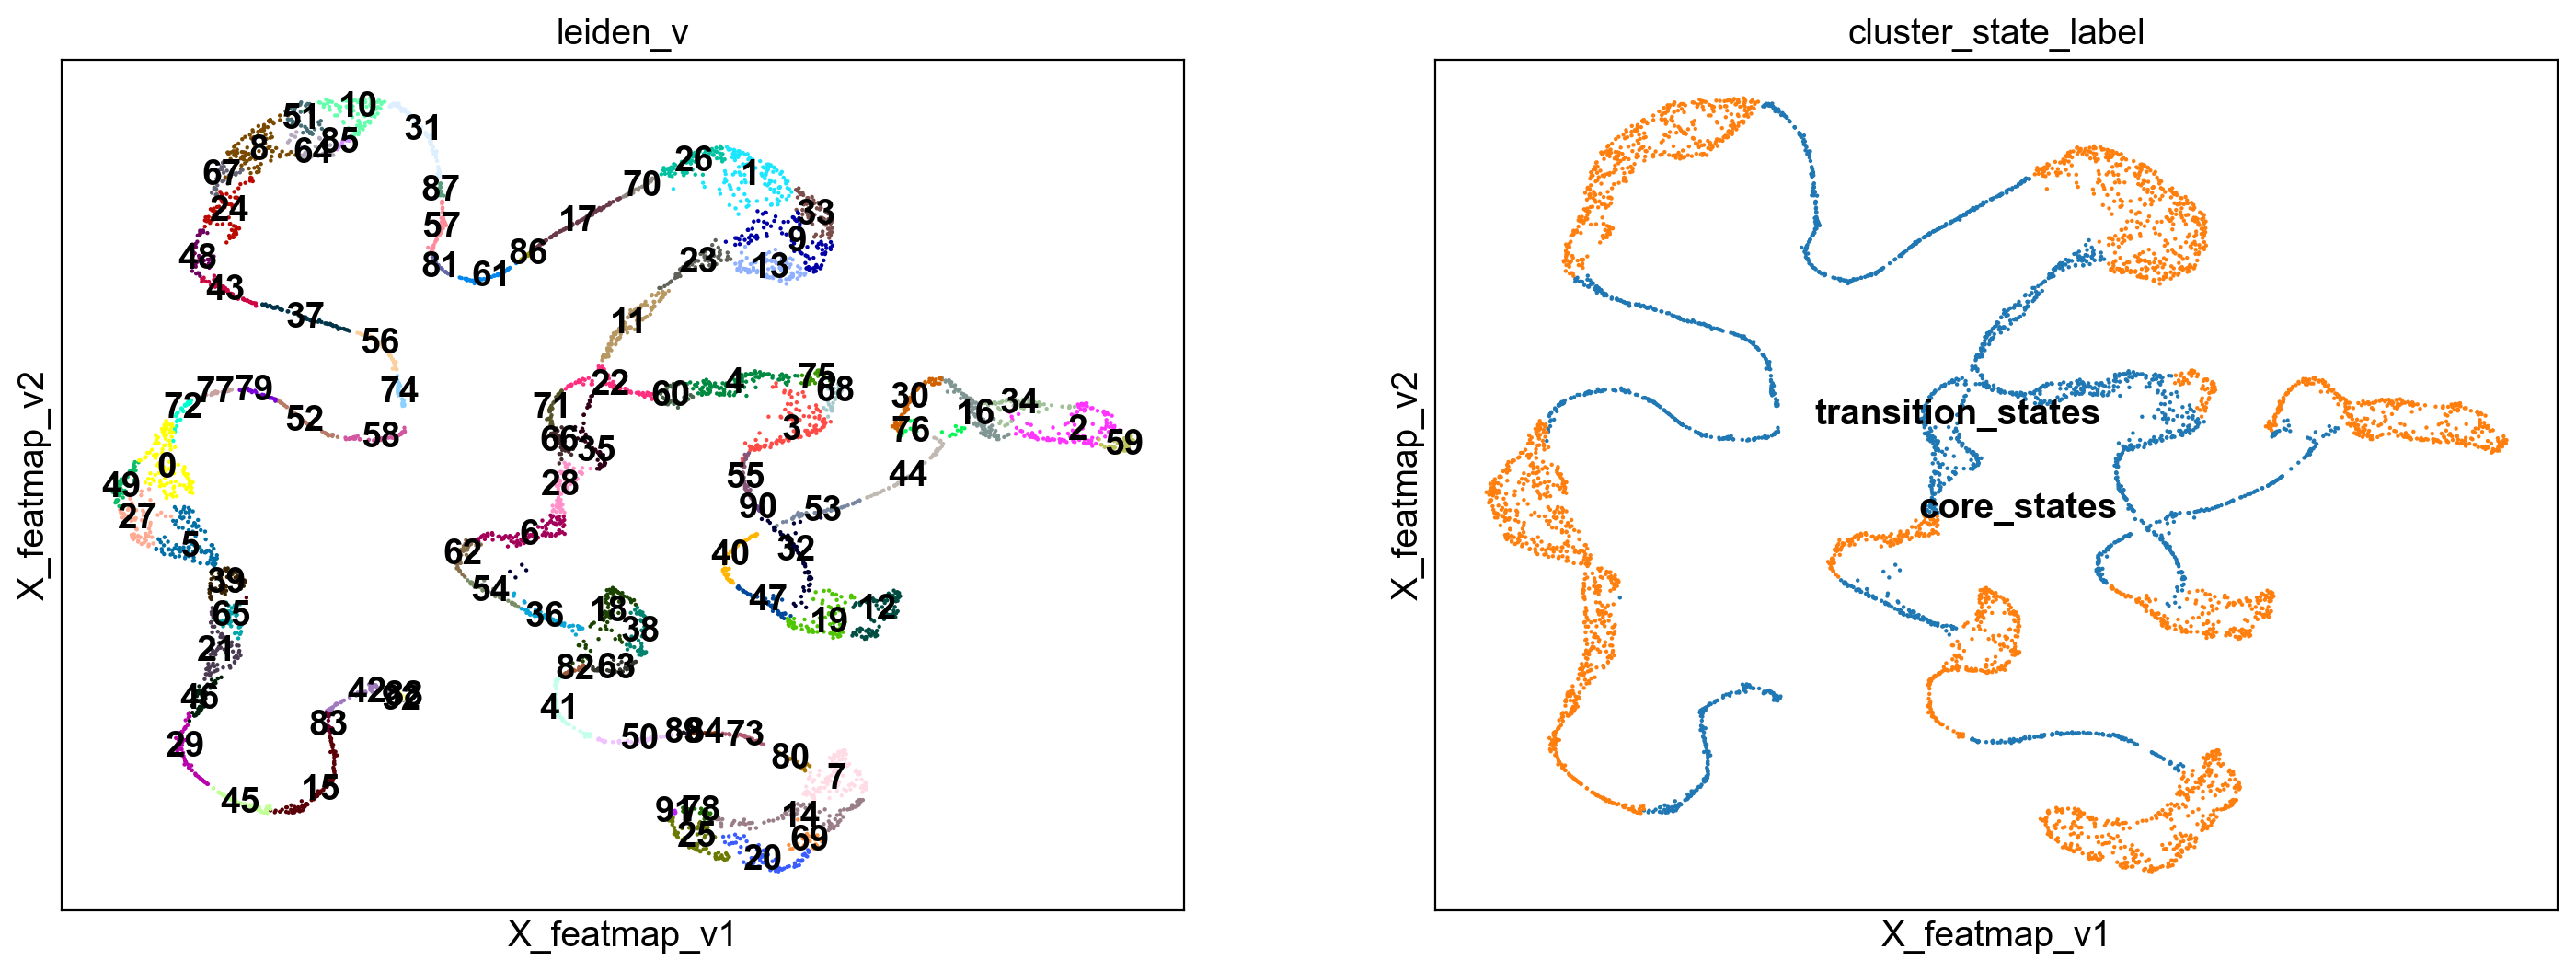

In [26]:
sc.set_figure_params(dpi=100, figsize=(8,6), )
sc.pl.embedding(adata, basis='X_featmap_v', color=['leiden_v', 'cluster_state_label'], cmap='viridis', s=10, legend_loc='on data')

DGV compares transition state with core state in the bifurcation divergent to correctly identify the regulation genes.

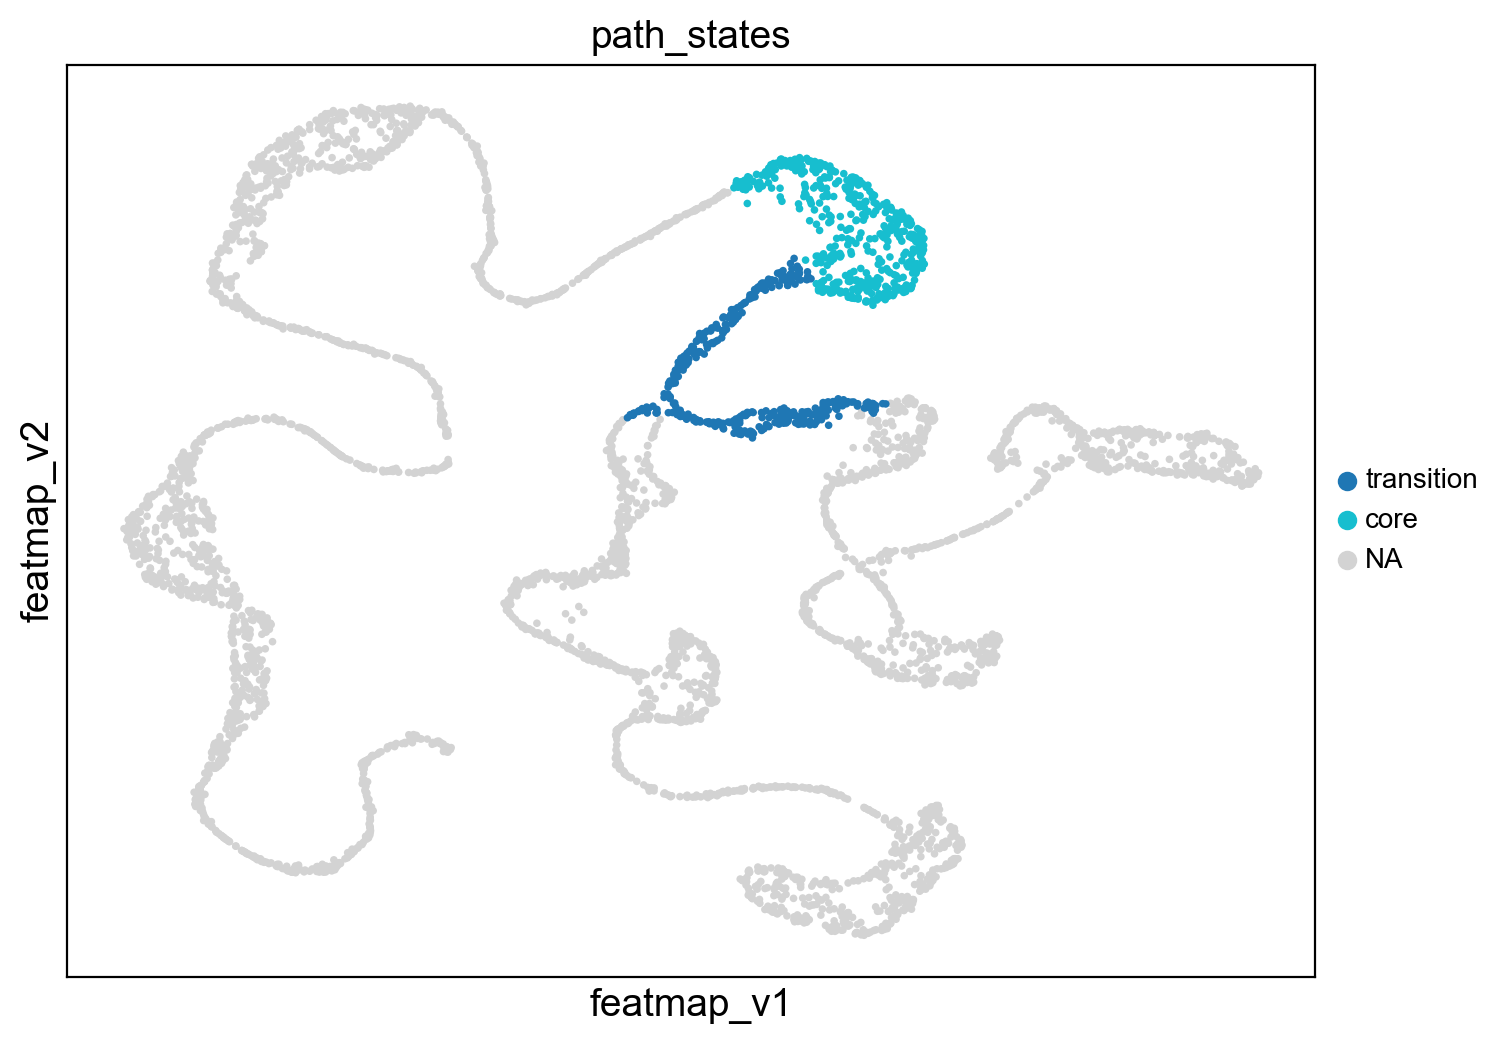

For this branch, the key regulatory genes are $g_4$


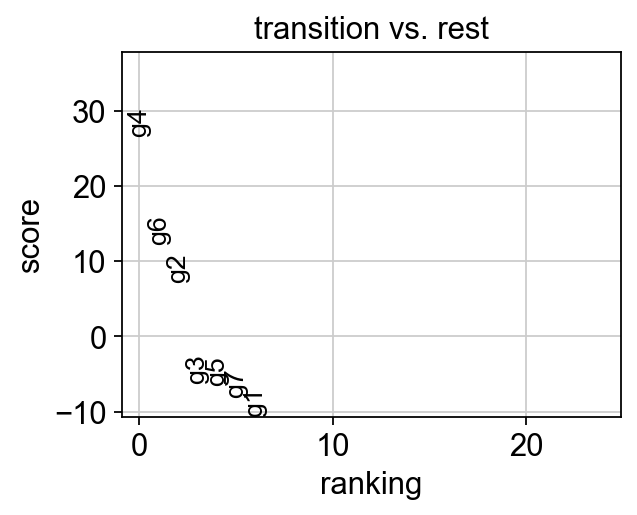

In [27]:

from featuremap import features
import importlib
importlib.reload(features)

# During the bifurcation, select the core states and transition states by leiiden clustering
core_states = [ 13, 9, 33, 1, 26]
transition_states_1 = [23,11]
transition_states_2 = [22, 60, 4]
transition_states_3 = [71, 66, 35,28]

# merge the transition_1 and transition_2
transition_states = transition_states_1 + transition_states_2

from featuremap import core_transition_states
# plot the selected core states and transition states
core_transition_states.path_plot(adata, core_states, transition_states)

print('For this branch, the key regulatory genes are $g_4$')

# DGV analysis
sc.set_figure_params(dpi=80, figsize=(4, 3), frameon=False )
sc.tl.rank_genes_groups(adata, groupby='path_states', groups=['transition'],   method='wilcoxon', use_raw=False, layer='variation_feature')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False, fontsize=12)
# Top 5 genes in rank_genes_groups
top_genes = adata.uns['rank_genes_groups']['names']['transition'][:5]



Gene expression, gene variation and gene projection visualization.

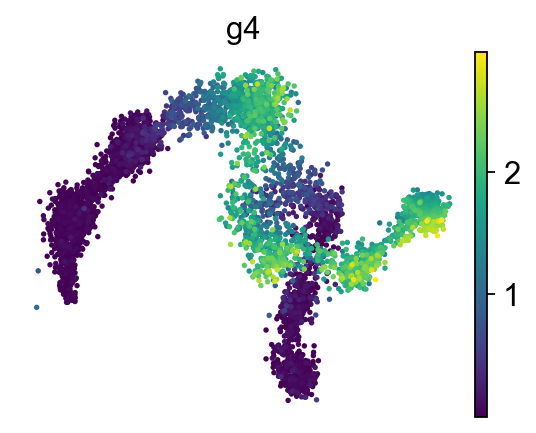

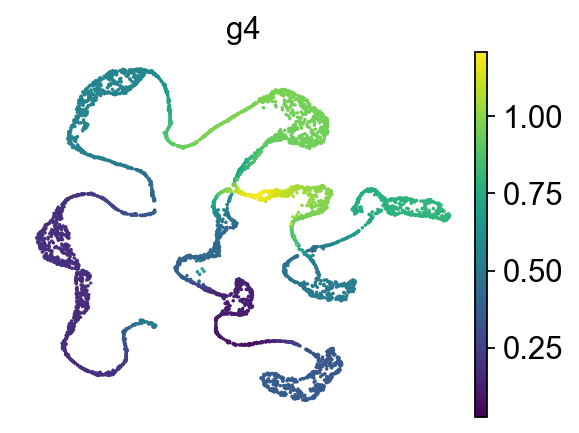

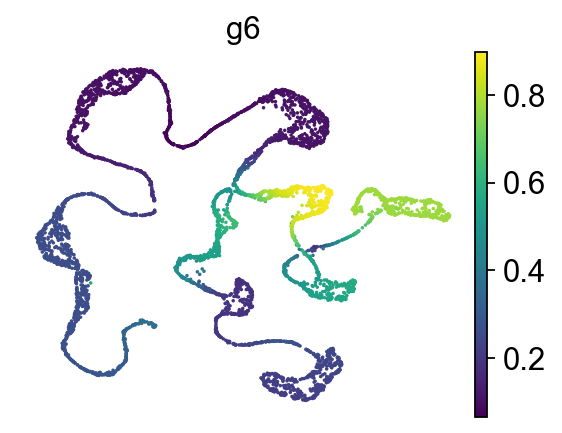

Start matrix multiplication
Finish matrix multiplication in 0.0005328655242919922
pcVals_project_back_feature: (5000, 2, 1)
gauge_vh_emb: (5000, 2, 2)


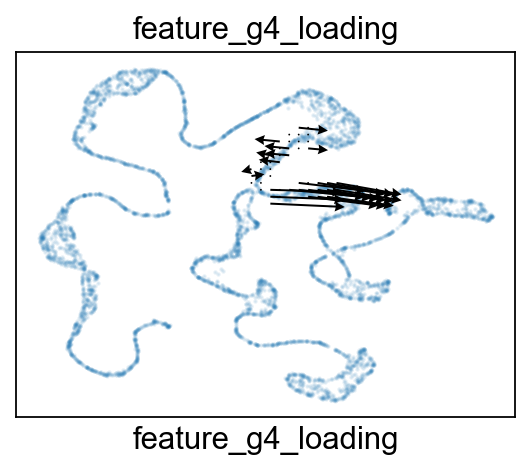

Start matrix multiplication
Finish matrix multiplication in 0.0005240440368652344
pcVals_project_back_feature: (5000, 2, 1)
gauge_vh_emb: (5000, 2, 2)


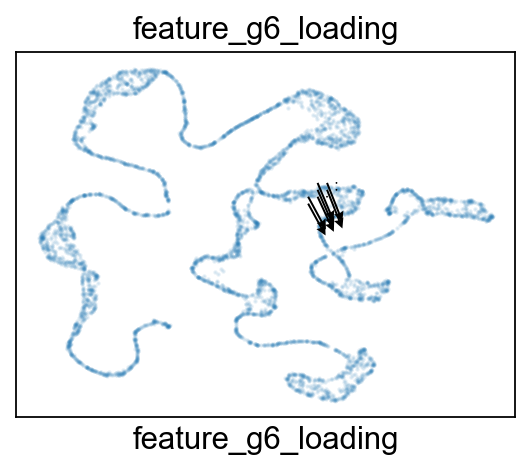

In [28]:

gene = 'g4'
sc.pl.embedding(adata, 'featmap' ,color=[gene],)
sc.pl.embedding(adata, 'featmap_v' ,color=[gene], cmap='viridis', s=10, legend_loc='on data', frameon=False, layer='variation_feature')
sc.pl.embedding(adata, 'featmap_v' ,color='g6', cmap='viridis', s=10, legend_loc='on data', frameon=False, layer='variation_feature')

from featuremap import features
import importlib
importlib.reload(features)

features.feature_projection(adata, feature=gene, vkey='VH_embedding')
features.feature_variation_one_feature(adata, feature=gene)
features.plot_one_feature(adata, feature=gene, ratio=0.5, density=1, embedding='X_featmap_v',
                               pseudotime='dpt_pseudotime', pseudotime_adjusted=True, cluster_key='path_states',
                               plot_within_cluster=['transition']
                               )  

gene = 'g6'
features.feature_projection(adata, feature=gene, vkey='VH_embedding')
features.feature_variation_one_feature(adata, feature=gene)
features.plot_one_feature(adata, feature=gene, ratio=0.5, density=1, embedding='X_featmap_v',
                               pseudotime='dpt_pseudotime', pseudotime_adjusted=True, cluster_key='path_states',
                               plot_within_cluster=['transition']
                               )  



For the other branch, $g_5$ is the regulatory gene.

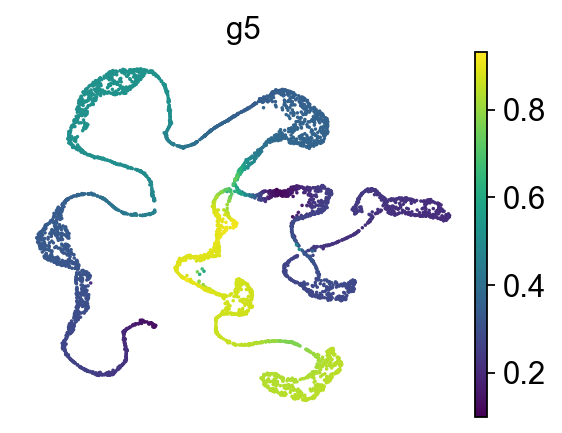

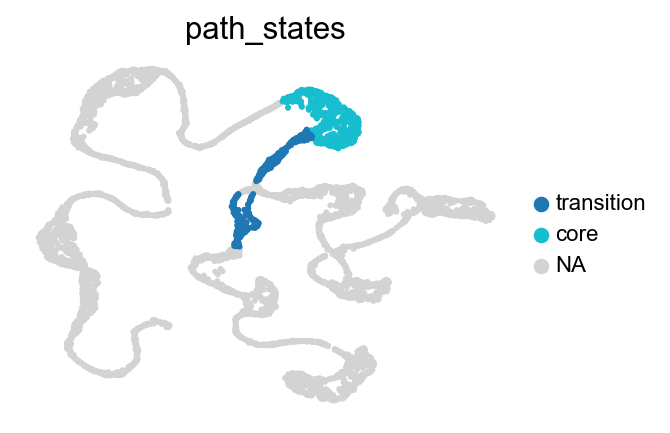

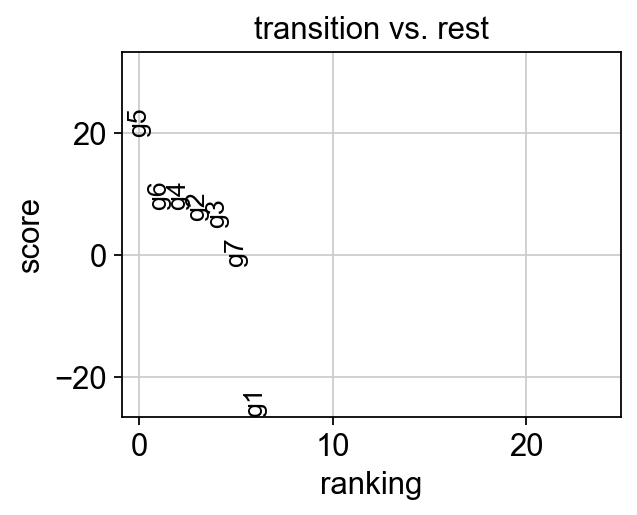

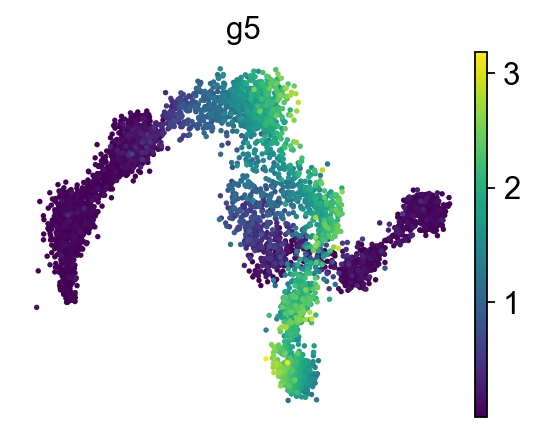

Rank of g5 is  [0] in transition
Start matrix multiplication
Finish matrix multiplication in 0.000553131103515625
pcVals_project_back_feature: (5000, 2, 1)
gauge_vh_emb: (5000, 2, 2)


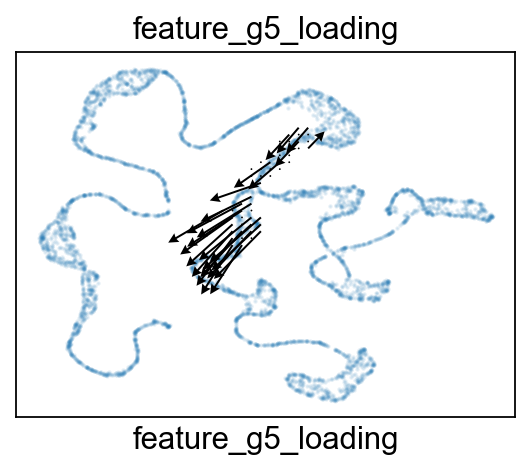

In [29]:
sc.pl.embedding(adata, 'featmap_v' ,color='g5', cmap='viridis', s=10, legend_loc='on data', frameon=False, layer='variation_feature')

# merge the transition_1 and transition_3
transition_states = transition_states_1 + transition_states_3
from featuremap import core_transition_states
# plot the selected core states and transition states
core_transition_states.path_plot(adata, core_states, transition_states)

# DGV analysis
sc.set_figure_params(dpi=80, figsize=(4, 3), frameon=False )
sc.tl.rank_genes_groups(adata, groupby='path_states', groups=['transition'],   method='wilcoxon', use_raw=False, layer='variation_feature')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False, fontsize=12)
# Top 5 genes in rank_genes_groups
top_genes = adata.uns['rank_genes_groups']['names']['transition'][:5]

gene = 'g5'
sc.pl.embedding(adata, 'featmap' ,color=[gene],)
rank = np.where(adata.uns['rank_genes_groups']['names']['transition'] == gene)[0]
print(f'Rank of {gene} is  {rank} in transition')

features.feature_projection(adata, feature=gene, vkey='VH_embedding')
features.feature_variation_one_feature(adata, feature=gene)
features.plot_one_feature(adata, feature=gene, ratio=0.5, density=1, embedding='X_featmap_v',
                               pseudotime='dpt_pseudotime', pseudotime_adjusted=True, cluster_key='path_states',
                               plot_within_cluster=['transition']
                               )  